## In this notebook I try different algorithms and techniques in order to optimize results in sinal-background seperation
The main algorithms used are: AdaBoost, XGBoost, CatBoost, Random Forest
Finally, I manage to accomplish similar result with the existing TMVA model, using XGBoost and CatBoost algorithms
In all these efforts I used the same 14 variables accessible from root files

Best Models: 


10 - 1 ds  \
a) (max_depth = 4, n_estimators=30,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5) 

b) (max_depth = 4, n_estimators=50,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5) cut 398/400 

c)(max_depth = 4, n_estimators=60,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5) cut 398/400 BEST 

d) (max_depth = 4, n_estimators=40,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5)  cut 397/400 


1-1 ds

e) (max_depth = 4, n_estimators=60,  eta=0.2, eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5) cut 391/400

----- primary importance: eta = 0.2

f) CatBoost( iterations=9, learning_rate=0.8,  loss_function='CrossEntropy')  10-1 ds

In [5]:
import uproot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
muons_scale = 5825876.1 / 9817299.000
atm_nu_scale = 5825876.1
cosmic_nu_scale = 5825876.1

### Load training dataset
Several techniques are used

In [8]:
#obtain data from root file
netr = 'Train/forBDT_Train_ML_All_NuAnu_ARCA19_ARCA21_v8.1_First_Up_WR.root'
muon = 'Train/forBDT_Train_ML_All_Muons_ARCA19_ARCA21_v8.1_First_Up_br.root'
netr = uproot.open(netr)['ProcessedEvents_forBDT']
muon = uproot.open(muon)['ProcessedEvents_forBDT;1']
#make list of variables to use
vrs = "downsol logbeta0 normdlik ratio_lower_nhits max_diff_sol TrLengthIT_2 ratio110 float_num_triggered_lines \
min_zen_sol num_of_good_sol float_num_cherenkov_doms best_trk_pos_z jlik best_trk_dir_shower_z".split(' ')

#crate one dataframe for all vars 
df_n = netr[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_n = pd.concat([df_n, netr[v].arrays(library = 'pd') ], axis=1, join='inner')
df_m = muon[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_m = pd.concat([df_m, muon[v].arrays(library = 'pd') ], axis=1, join='inner')

In [ ]:
netr['logE_nu'].arrays(library = 'pd')

Create 10 different datasets with random 7 out of 14 variables

In [34]:
from random import sample
df_t = []
yn = pd.DataFrame({'id': len(df_n.index)*[1]})
ym = pd.DataFrame({'id': len(df_m.index)*[0]})
vrs_t = [sample(vrs, 7) for i in range(10)]
for vr in vrs_t:
    df_n_t = netr[vr[0]].arrays(library = 'pd')
    for v in vr[1:]:
        df_n_t = pd.concat([df_n_t, netr[v].arrays(library = 'pd') ], axis=1, join='inner')
    df_m_t = muon[vr[0]].arrays(library = 'pd')
    for v in vr[1:]:
        df_m_t = pd.concat([df_m_t, muon[v].arrays(library = 'pd') ], axis=1, join='inner')

    df_n_t = pd.concat([df_n_t, yn], axis=1, join='inner')
    df_m_t = pd.concat([df_m_t, ym], axis=1, join='inner')

    df_n1_t = df_n_t.sample(1 * len(df_m_t.index))
    df1_t = pd.concat([df_n1_t, df_m_t]).sample(frac=1)
    df_t.append(df1_t)


In [54]:
df_n.shape, df_m.shape

((436517, 15), (5199, 15))

### Scaling neutrinos
There is a large assymetry between neutrinos and muons classes and thats why I try to scale neutrino dataset \
After scaling muons seem to be 10 time the number of neutrinos

In [4]:
ice_n_d = netr['w3ice'].arrays(library='np')['w3ice']
atm_n_d = netr['w3atm'].arrays(library='np')['w3atm']
sum(len(df_m.index)*[muons_scale]), sum(atm_n_d) * atm_nu_scale ## ill take all neutrinos..

(3085.2406393958295, 368.24822851095746)

Take all muons and neutrinos scaled

In [11]:
df_ns = pd.concat([df_n, atm_nu_scale * netr['w3atm'].arrays(library = 'pd') ], axis=1, join='inner')
df_ms = pd.concat([df_m, pd.DataFrame({'w3atm': len(df_m.index)*[muons_scale]})], axis=1, join='inner')
#ground trouth for netr and muons
yn = pd.DataFrame({'id': len(df_ns.index)*[1]})
ym = pd.DataFrame({'id': len(df_ms.index)*[0]})
#make one shuffled df
df_ns = pd.concat([df_ns, yn], axis=1, join='inner')
df_ms = pd.concat([df_ms, ym], axis=1, join='inner')

df_s = pd.concat([df_ns, df_ms]).sample(frac=1)

In [6]:
print(df_ns.shape, df_ms.shape, df_s.shape)

(436517, 16) (5199, 16) (441716, 16)


Take 10 minibatches of muons and all neutrinos (10 differnet datasets)

In [7]:
df_ms_m = [df_ms.sample(368) for i in range(10)]
df_s_m = [pd.concat([df_ns, df__]).sample(frac=1) for df__ in df_ms_m]

### The simplest way
-Just take as many neutrinos as muons \
-Take 10 times more neutrinos so as not to discard much data

df1 -> 1-1 training dataset
df_ ->10-1 training dataset

In [9]:
#ground trouth for netr and muons
yn = pd.DataFrame({'id': len(df_n.index)*[1]})
ym = pd.DataFrame({'id': len(df_m.index)*[0]})
#make one shuffled df
df_n = pd.concat([df_n, yn], axis=1, join='inner')
df_m = pd.concat([df_m, ym], axis=1, join='inner')

df_n1 = df_n.sample(1 * len(df_m.index))
df1 = pd.concat([df_n1, df_m]).sample(frac=1)
print(df_n1.shape, df_m.shape, df1.shape)


df_n2 = df_n.sample(10 * len(df_m.index))
df_ = pd.concat([df_n2, df_m]).sample(frac=1)
print(df_n2.shape, df_m.shape, df_.shape)

(5199, 15) (5199, 15) (10398, 15)
(51990, 15) (5199, 15) (57189, 15)


## Model Training
Here I start training different models on the differnet previously created datasets
 

In [13]:
### Split to train and test set
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
#1-1 dataset
X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:-1], df1['id'], test_size=0.2, random_state=42)
#10-1 dataset
X_train_, X_test_, y_train_, y_test_ = train_test_split(df_.iloc[:,:-1], df_['id'], test_size=0.2, random_state=42)
#scaled dataset
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df_s.iloc[:,:-1], df_s['id'], test_size=0.2, random_state=42)

In [10]:
#split 10 datasets for 10 minibatches of muons model
X_train_s_m = []
X_test_s_m = []
y_train_s_m = [] 
y_test_s_m = []
for df in df_s_m:
    X_t, X_te, y_t, y_te = train_test_split(df.iloc[:,:-1], df['id'], test_size=0.2, random_state=42)
    X_train_s_m.append(X_t)
    X_test_s_m.append(X_te)
    y_train_s_m.append(y_t)
    y_test_s_m.append(y_te)

In [47]:
#split dataset for 7 random vars model
X_train_t = []
X_test_t = []
y_train_t = [] 
y_test_t = []
for dt in df_t:
    X_t, X_te, y_t, y_te = train_test_split(dt.iloc[:,:-1], dt['id'], test_size=0.2, random_state=42)
    X_train_t.append(X_t)
    X_test_t.append(X_te)
    y_train_t.append(y_t)
    y_test_t.append(y_te)

### Train XGBoost Models

In [ ]:
### xgb model
model_xgb = XGBClassifier(max_depth = 4, n_estimators=30)  
print(model_xgb.fit(X_train, y_train))
model_xgb_ = XGBClassifier(max_depth = 4, n_estimators=60)  
model_xgb_.fit(X_train_, y_train_)

In [ ]:
## scaled xgb
model_xgb_s = XGBClassifier(max_depth = 6, n_estimators=200)  
model_xgb_s.fit(X_train_s.iloc[:,:-1], y_train_s, sample_weight=X_train_s['w3atm'])

In [ ]:
### xgb with 7 vars
model_xgb_t = [XGBClassifier(max_depth = 4, n_estimators=40) for i in range(10)]
for m, x, y in zip(model_xgb_t, X_train_t, y_train_t):
    m.fit(x, y)

In [ ]:
## 10 mini xgb
model_xgb_s_m = [XGBClassifier(max_depth = 4, n_estimators=100) for i in range(10)]
for m, x, y in zip(model_xgb_s_m, X_train_s_m, y_train_s_m):
    m.fit(x.iloc[:,:-1], y, sample_weight=x['w3atm'])

### random forest

In [14]:
#### random forest
from sklearn.ensemble import RandomForestClassifier
model_rnd= RandomForestClassifier(n_estimators=200)  #, early_stopping_rounds=5) #, eval_metric=recall_score)
model_rnd.fit(X_train, y_train) #, sample_weight=X_train['w3atm']) #,  eval_set=[(X_test, y_test)])
model_rnd_ = RandomForestClassifier(n_estimators=200)  #, early_stopping_rounds=5) #, eval_metric=recall_score)
model_rnd_.fit(X_train_, y_train_) #, sample_weight=X_train['w3atm']) #,  eval_set=[(X_test, y_test)])

RandomForestClassifier(n_estimators=200)

### Catboost

In [15]:
from catboost import CatBoostClassifier
model_ctb = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)

model_ctb.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        verbose=False
)

### XGBRegressor

In [ ]:
model_xgbr = XGBRegressor(max_depth = 4, n_estimators=100)  #, early_stopping_rounds=5) #, eval_metric=recall_score)
model_xgbr.fit(X_train, y_train)

### SVM

In [17]:
from sklearn.svm import SVC
model_svm = SVC(kernel='rbf', degree=3, probability=True)
model_svm.fit(X_train, y_train)

SVC(probability=True)

### AdaBoost Classifier once more

In [15]:
## ada_boost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
estim = DecisionTreeClassifier(max_depth=6)
model_ada = AdaBoostClassifier(estimator = estim, n_estimators=1200, learning_rate=0.02)
model_ada.fit(X_train_ ,y_train_)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.02, n_estimators=1200)

### Overfitting check (A test on estimators needed for XGBoost Classifier)

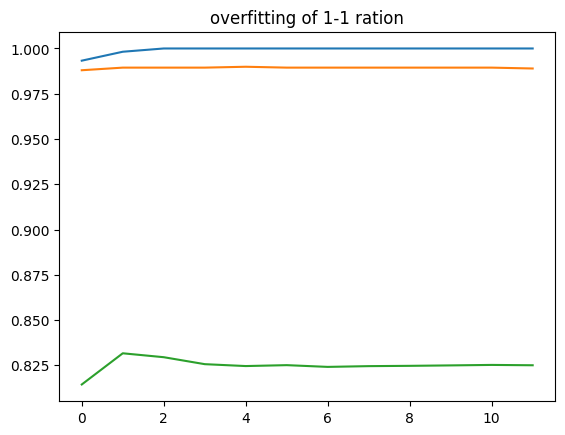

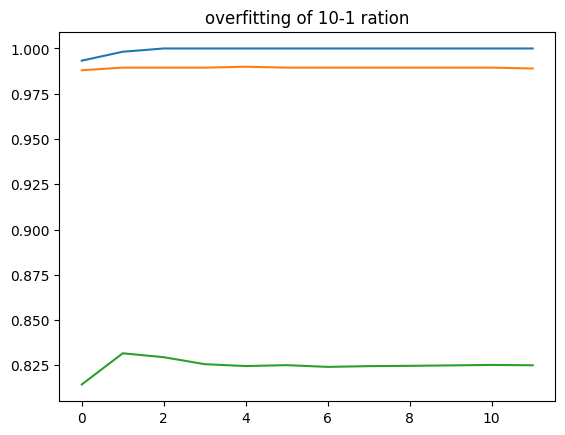

In [14]:
acc_tr=[]
acc_test=[]
acc_eval = []
for i in range(12):
    model_xgb_oc = XGBClassifier(max_depth = 4, n_estimators=30*i+10)  
    model_xgb_oc.fit(X_train, y_train)
    acc_tr.append(accuracy_score(y_train, model_xgb_oc.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model_xgb_oc.predict(X_test)))
    pred_eval_n = model_xgb_oc.predict(df_n_eval)
    pred_eval_m = model_xgb_oc.predict(df_m_eval)
    acc_eval.append((1 + sum(pred_eval_n) - sum(pred_eval_m)) / (len(pred_eval_n) + len(pred_eval_m)))
plt.plot(acc_tr)
plt.plot(acc_test)
plt.plot(acc_eval)
plt.title('overfitting of 1-1 ration')
plt.show()

acc_tr=[]
acc_test=[]
acc_eval = []
for i in range(12):
    model_xgb_oc = XGBClassifier(max_depth = 4, n_estimators=30*i+10)  
    model_xgb_oc.fit(X_train, y_train)
    acc_tr.append(accuracy_score(y_train, model_xgb_oc.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model_xgb_oc.predict(X_test)))
    pred_eval_n = model_xgb_oc.predict(df_n_eval)
    pred_eval_m = model_xgb_oc.predict(df_m_eval)
    acc_eval.append((1 + sum(pred_eval_n) - sum(pred_eval_m)) / (len(pred_eval_n) + len(pred_eval_m)))
plt.plot(acc_tr)
plt.plot(acc_test)
plt.plot(acc_eval)
plt.title('overfitting of 10-1 ration')
plt.show()

### performance on test set

In [44]:
print("1-1 dataset:")
p = model_xgb.predict(X_test)
print(accuracy_score(y_test, p), precision_score(y_test, p), recall_score(y_test, p))
print(confusion_matrix(y_test, p))

print("10-1 dataset:")
p_ = model_xgb_.predict(X_test_)
print(accuracy_score(y_test_, p_), precision_score(y_test_, p_), recall_score(y_test_, p_))
print(confusion_matrix(y_test_, p_))

print("scaled dataset:")
p_s = model_xgb_s.predict(X_test_s.iloc[:,:-1])
print(accuracy_score(y_test_s, p_s), precision_score(y_test_s, p_s), recall_score(y_test_s, p_s))
print(confusion_matrix(y_test_s, p_s))

print("random forest 1-1:")
p_r = model_rnd.predict(X_test)
print(accuracy_score(y_test, p_r), precision_score(y_test, p_r), recall_score(y_test, p_r))
print(confusion_matrix(y_test, p_r))

print("random forest 10-1:")
p_r_ = model_rnd_.predict(X_test_)
print(accuracy_score(y_test_, p_r_), precision_score(y_test_, p_r_), recall_score(y_test_, p_r_))
print(confusion_matrix(y_test_, p_r_))

print("svm:")
p_svm = model_svm.predict(X_test)
print(accuracy_score(y_test, p_svm), precision_score(y_test, p_svm), recall_score(y_test, p_svm))
print(confusion_matrix(y_test, p_svm))

print("ada boost:")
p_ada = model_ada.predict(X_test)
print(accuracy_score(y_test, p_ada), precision_score(y_test, p_ada), recall_score(y_test, p_ada))
print(confusion_matrix(y_test, p_ada))

print("cat boost:")
p_cat = model_ctb.predict(X_test)
print(accuracy_score(y_test, p_cat), precision_score(y_test, p_cat), recall_score(y_test, p_cat))
print(confusion_matrix(y_test, p_ada))

print("10 mini xgboost")
pred_10 = model_xgb_s_m[0].predict(X_test) * 0.1
for m in model_xgb_s_m[1:]:
    pred_10+= m.predict(X_test) * 0.1
pred_10 = np.round(pred_10)

print(accuracy_score(y_test, pred_10), precision_score(y_test, pred_10), recall_score(y_test, pred_10))
print(confusion_matrix(y_test, pred_10))

1-1 dataset:
0.9889423076923077 0.9862068965517241 0.9910891089108911
[[1056   14]
 [   9 1001]]
10-1 dataset:
0.9951040391676866 0.9967351642020357 0.9978850221111325
[[ 1002    34]
 [   22 10380]]
scaled dataset:
0.9897106764466178 0.9998612283602974 0.9897319077817716
[[  974    12]
 [  897 86461]]
random forest 1-1:
0.9918269230769231 0.9930486593843099 0.9900990099009901
[[1063    7]
 [  10 1000]]
random forest 10-1:
0.9946668998076587 0.9966381711651138 0.997500480676793
[[ 1001    35]
 [   26 10376]]
svm:
0.9625 0.9650698602794411 0.9574257425742574
[[1035   35]
 [  43  967]]
ada boost:
0.9951923076923077 0.9921259842519685 0.998019801980198
[[1062    8]
 [   2 1008]]
cat boost:
0.9783653846153846 0.9781962338949455 0.9772277227722772
[[1062    8]
 [   2 1008]]
10 mini xgboost
0.96875 0.9428303655107779 0.996039603960396
[[1009   61]
 [   4 1006]]


In [ ]:
print("5 vars xgboost:")
for m, x, y in zip(model_xgb_t, X_test_t, y_test_t):
    p_t = m.predict(x)
    print(accuracy_score(y, p_t), precision_score(y, p_t), recall_score(y, p_t))
    print(confusion_matrix(y, p_t))
    print(' ')

In [71]:
print("xgb regressor:")
p_xgbr = [1 if i> 0.5 else 0 for i in model_xgbr.predict(X_test)]
print(accuracy_score(y_test, p_xgbr), precision_score(y_test, p_xgbr), recall_score(y_test, p_xgbr))
print(confusion_matrix(y_test, p_xgbr))

xgb regressor:
0.9855769230769231 0.9841897233201581 0.9861386138613861
[[1054   16]
 [  14  996]]


### performance on training set

In [46]:
print("1-1 dataset:")
p = model_xgb.predict(X_train)
print(accuracy_score(y_train, p), precision_score(y_train, p), recall_score(y_train, p))
print(confusion_matrix(y_train, p))

print("10-1 dataset:")
p_ = model_xgb_.predict(X_train_)
print(accuracy_score(y_train_, p_), precision_score(y_train_, p_), recall_score(y_train_, p_))
print(confusion_matrix(y_train_, p_))

print("scaled dataset:")
p_s = model_xgb_s.predict(X_train_s.iloc[:,:-1])
print(accuracy_score(y_train_s, p_s), precision_score(y_train_s, p_s), recall_score(y_train_s, p_s))
print(confusion_matrix(y_train_s, p_s))

print("random forest:")
p_r = model_rnd.predict(X_train)
print(accuracy_score(y_train, p_r), precision_score(y_train, p_r), recall_score(y_train, p_r))
print(confusion_matrix(y_train, p_r))

print("random forest 10:")
p_r_ = model_rnd.predict(X_train_)
print(accuracy_score(y_train_, p_r_), precision_score(y_train_, p_r_), recall_score(y_train_, p_r_))
print(confusion_matrix(y_train_, p_r_))

print("svm:")
p_svm = model_svm.predict(X_train)
print(accuracy_score(y_train, p_svm), precision_score(y_train, p_svm), recall_score(y_train, p_svm))
print(confusion_matrix(y_train, p_svm))

print("ada boost:")
p_ada = model_ada.predict(X_train)
print(accuracy_score(y_train, p_ada), precision_score(y_train, p_ada), recall_score(y_train, p_ada))
print(confusion_matrix(y_train, p_ada))

print("cat boost:")
p_cat = model_ctb.predict(X_train)
print(accuracy_score(y_train, p_cat), precision_score(y_train, p_cat), recall_score(y_train, p_cat))
print(confusion_matrix(y_train, p_ada))

print("10 mini xgboost")
pred_10 = model_xgb_s_m[0].predict(X_train) * 0.1
for m in model_xgb_s_m[1:]:
    pred_10+= m.predict(X_train) * 0.1
pred_10 = np.round(pred_10)

print(accuracy_score(y_train, pred_10), precision_score(y_train, pred_10), recall_score(y_train, pred_10))
print(confusion_matrix(y_train, pred_10))

1-1 dataset:
0.9966338062034142 0.9976082276967233 0.995703031749821
[[4119   10]
 [  18 4171]]
10-1 dataset:
0.9978361128718498 0.9988697304186807 0.9987496393190344
[[ 4116    47]
 [   52 41536]]
scaled dataset:
0.990191639405499 1.0 0.9900732903920564
[[  4213      0]
 [  3466 345693]]
random forest:
1.0 1.0 1.0
[[4129    0]
 [   0 4189]]
random forest 10:
0.9862516666302376 0.9998779565036979 0.9849956718284121
[[ 4158     5]
 [  624 40964]]
svm:
0.9590045684058668 0.9658595641646489 0.952255908331344
[[3988  141]
 [ 200 3989]]
ada boost:
0.9949507093051214 0.9935729588193287 0.9964191931248508
[[4102   27]
 [  15 4174]]
cat boost:
0.9818465977398413 0.9860375541646605 0.9777989973740749
[[4102   27]
 [  15 4174]]
10 mini xgboost
0.973551334455398 0.9527720739219713 0.9968966340415374
[[3922  207]
 [  13 4176]]


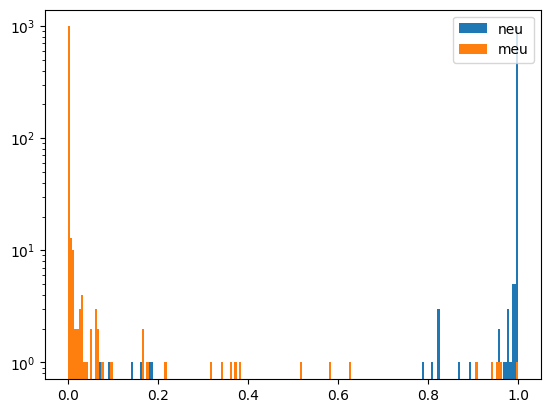

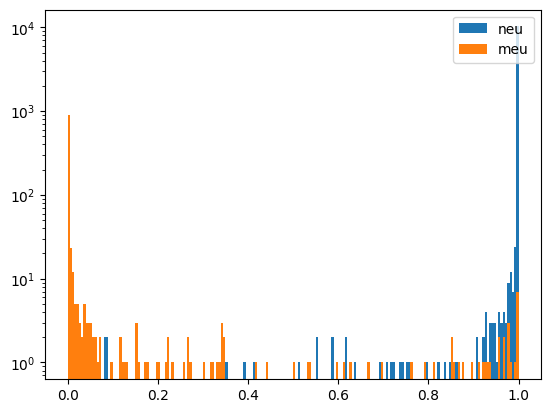

In [37]:
y_test_n = y_test.to_frame()
X_test_n = X_test[y_test_n['id']==1]
X_test_m = X_test[y_test_n['id']==0]
X_test_m.shape, X_test_n.shape, X_test.shape

probn = model_xgb.predict_proba(X_test_n)
#plt.hist(prob[:,1], 200, weights= X_test_n['w3atm'], log=True, label='neu')
#plt.hist(prob[:,1], 200, weights= atm_nu_scale * X_test_n['w3atm'], log=True, label='neu')
n2, x2, _ = plt.hist(probn[:,1], 200, log=True, label='neu')

probm = model_xgb.predict_proba(X_test_m)
#plt.hist(prob[:,1], 200, weights= [muons_scale] * prob[:,1].shape[0], log=True, label='meu')
n1, x1, _ = plt.hist( probm[:,1], 200, log=True, label='meu')
plt.legend(loc='upper right')
plt.show()

y_test_n = y_test_.to_frame()
X_test_n = X_test_[y_test_n['id']==1]
X_test_m = X_test_[y_test_n['id']==0]
X_test_m.shape, X_test_n.shape, X_test.shape

probn_ = model_xgb_.predict_proba(X_test_n)
#plt.hist(prob[:,1], 200, weights= X_test_n['w3atm'], log=True, label='neu')
#plt.hist(prob[:,1], 200, weights= atm_nu_scale * X_test_n['w3atm'], log=True, label='neu')
n2_, x2_, _ = plt.hist(probn_[:,1], 200, log=True, label='neu')

probm_ = model_xgb_.predict_proba(X_test_m)
#plt.hist(prob[:,1], 200, weights= [muons_scale] * prob[:,1].shape[0], log=True, label='meu')
n1_, x1_, _ = plt.hist( probm_[:,1], 200, log=True, label='meu')
plt.legend(loc='upper right')
plt.show()

### reliability diagrams

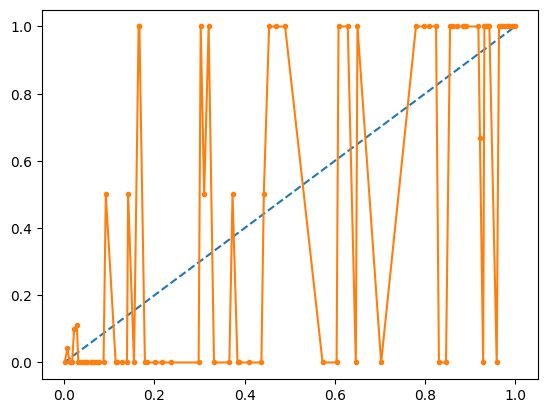

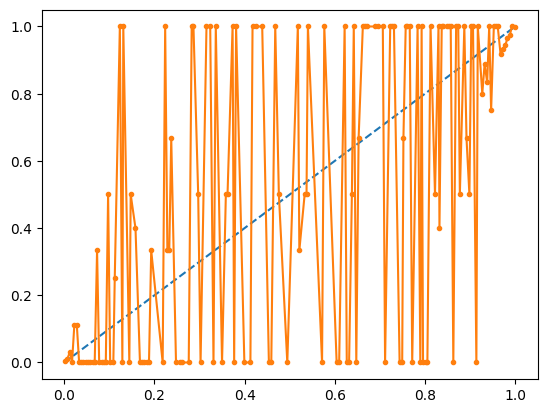

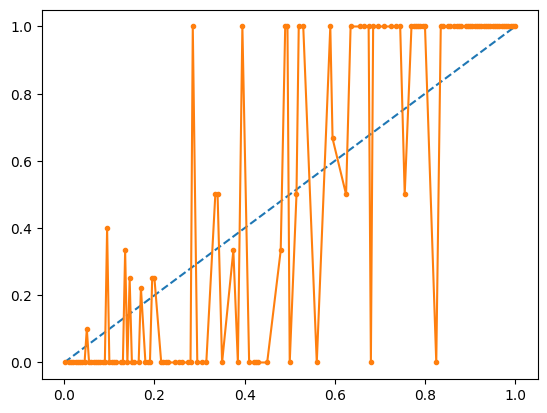

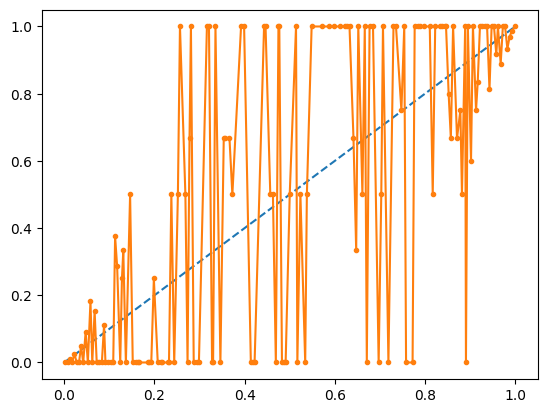

In [200]:
from sklearn.calibration import calibration_curve
x, y = calibration_curve(y_test, model_xgb.predict_proba(X_test)[:,1], n_bins=200)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(y, x, marker = '.', label = 'My model')
#leg = plt.legend(loc = 'lower left')
plt.show()

x, y = calibration_curve(y_test_, model_xgb_.predict_proba(X_test_)[:,1], n_bins=200)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(y, x, marker = '.', label = 'My model')
#leg = plt.legend(loc = 'lower left')
plt.show()
x, y = calibration_curve(y_test, model_rnd.predict_proba(X_test)[:,1], n_bins=200)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(y, x, marker = '.', label = 'My model')
#leg = plt.legend(loc = 'lower left')
plt.show()
x, y = calibration_curve(y_test, model_svm.predict_proba(X_test)[:,1], n_bins=200)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
plt.plot(y, x, marker = '.', label = 'My model')
#leg = plt.legend(loc = 'lower left')

### Evaluation Set
evaluate all these models on eval set

In [68]:
muon_ev = 'Evaluation/forBDT_mine_muons_All_ARCA21_v8.1_bdt_branch.root'
netr_ev = "Evaluation/forBDT_mine_a-nu_Mu_CC_All_ARCA21_v8.1_bdt_branch.root" #'Evaluation/forBDT_mine_a-nu_FLAVOURS_combined_all_ARCA21_v8.1_bdt_branch.root'
muon_ev = uproot.open(muon_ev)['ProcessedEvents_forBDT;1']
netr_ev = uproot.open(netr_ev)['ProcessedEvents_forBDT;54']
muons_scale = 5825876.1 / 9817299.000
atm_nu_scale = 5825876.1
cosmic_nu_scale = 5825876.1
df_n_eval = netr_ev[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_n_eval = pd.concat([df_n_eval, netr_ev[v].arrays(library = 'pd') ], axis=1, join='inner')
df_m_eval = muon_ev[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_m_eval = pd.concat([df_m_eval, muon_ev[v].arrays(library = 'pd') ], axis=1, join='inner')

In [11]:
muons_scale = 5825876.1 / 9817299.000
atm_nu_scale = 5825876.1
cosmic_nu_scale = 5825876.1
ev = "Evaluation/forBDT_mine_a-nu_Mu_CC_All_ARCA21_v8.1_bdt_branch.root"
ev = uproot.open(ev)['ProcessedEvents_forBDT;54']
df_eval = ev[vrs[0]].arrays(library = 'pd')
for v in vrs[1:]:
    df_eval = pd.concat([df_eval, ev[v].arrays(library = 'pd') ], axis=1, join='inner')

In [24]:
scores = ev['bdt_score'].array(library='pd')

In [55]:
Tr_n = netr_ev['logE_nu'].arrays(library = 'pd')
Tr_m = muon_ev['logE_mu'].arrays(library = 'pd')

Results without scaling

In [50]:
### xgboost
print("1-1 model")
pred_eval_n = model_xgb.predict(df_n_eval)
pred_eval_m = model_xgb.predict(df_m_eval)
print("accuracy on neutrinos: ", sum(pred_eval_n) / len(pred_eval_n))
print("accuracy on muons: ", 1 - sum(pred_eval_m) / len(pred_eval_m))
print(confusion_matrix([0]*pred_eval_m.shape[0] + [1]*pred_eval_n.shape[0], np.concatenate((pred_eval_m, pred_eval_n))) )

print("10-1 model")
pred_eval_n_ = model_xgb_.predict(df_n_eval)
pred_eval_m_ = model_xgb_.predict(df_m_eval)
print("accuracy on neutrinos: ", sum(pred_eval_n_) / len(pred_eval_n_))
print("accuracy on muons: ", 1 - sum(pred_eval_m_) / len(pred_eval_m_))
print(confusion_matrix([0]*pred_eval_m_.shape[0] + [1]*pred_eval_n_.shape[0], np.concatenate((pred_eval_m_, pred_eval_n_))) )

print("scaled model")
pred_eval_n_s = model_xgb_s.predict(df_n_eval)
pred_eval_m_s = model_xgb_s.predict(df_m_eval)
print("accuracy on neutrinos: ", sum(pred_eval_n_s) / len(pred_eval_n_s))
print("accuracy on muons: ", 1 - sum(pred_eval_m_s) / len(pred_eval_m_s))
print(confusion_matrix([0]*pred_eval_m_s.shape[0] + [1]*pred_eval_n_s.shape[0], np.concatenate((pred_eval_m_s, pred_eval_n_s))) )

print("random forest")
pred_eval_n_r = model_rnd.predict(df_n_eval)
pred_eval_m_r = model_rnd.predict(df_m_eval)
print("accuracy on neutrinos: ", sum(pred_eval_n_r) / len(pred_eval_n_r))
print("accuracy on muons: ", 1 - sum(pred_eval_m_r) / len(pred_eval_m_r))
print(confusion_matrix([0]*pred_eval_m_r.shape[0] + [1]*pred_eval_n_r.shape[0], np.concatenate((pred_eval_m_r, pred_eval_n_r))) )

print("random forest 10")
pred_eval_n_r_ = model_rnd_.predict(df_n_eval)
pred_eval_m_r_ = model_rnd_.predict(df_m_eval)
print("accuracy on neutrinos: ", sum(pred_eval_n_r_) / len(pred_eval_n_r_))
print("accuracy on muons: ", 1 - sum(pred_eval_m_r_) / len(pred_eval_m_r_))
print(confusion_matrix([0]*pred_eval_m_r_.shape[0] + [1]*pred_eval_n_r_.shape[0], np.concatenate((pred_eval_m_r_, pred_eval_n_r_))) )

print("cat boost")
pred_eval_n_ctb = model_ctb.predict(df_n_eval)
pred_eval_m_ctb = model_ctb.predict(df_m_eval)
print("accuracy on neutrinos: ", sum(pred_eval_n_ctb) / len(pred_eval_n_ctb))
print("accuracy on muons: ", 1 - sum(pred_eval_m_ctb) / len(pred_eval_m_ctb))
print(confusion_matrix([0]*pred_eval_m_ctb.shape[0] + [1]*pred_eval_n_ctb.shape[0], np.concatenate((pred_eval_m_ctb, pred_eval_n_ctb))) )


1-1 model
accuracy on neutrinos:  0.8326105860707738
accuracy on muons:  0.9895781637717121
[[  13958     147]
 [1953984 9719299]]
10-1 model
accuracy on neutrinos:  0.9020706514182857
accuracy on muons:  0.957107408720312
[[   13500      605]
 [ 1143157 10530126]]
scaled model
accuracy on neutrinos:  0.8190754049225055
accuracy on muons:  0.9864587025877348
[[  13914     191]
 [2111984 9561299]]
random forest
accuracy on neutrinos:  0.8190536458338241
accuracy on muons:  0.9910669975186104
[[  13979     126]
 [2112238 9561045]]
random forest 10
accuracy on neutrinos:  0.9141388073946293
accuracy on muons:  0.954413328606877
[[   13462      643]
 [ 1002282 10671001]]
cat boost
accuracy on neutrinos:  0.7880301539849587
accuracy on muons:  0.9814250265863169
[[  13843     262]
 [2474384 9198899]]


In [89]:
print("ada boost")
pred_eval_n_ctb = model_ada.predict(df_n_eval)
pred_eval_m_ctb = model_ada.predict(df_m_eval)
print("accuracy on neutrinos: ", sum(pred_eval_n_ctb) / len(pred_eval_n_ctb))
print("accuracy on muons: ", 1 - sum(pred_eval_m_ctb) / len(pred_eval_m_ctb))
print(confusion_matrix([0]*pred_eval_m_ctb.shape[0] + [1]*pred_eval_n_ctb.shape[0], np.concatenate((pred_eval_m_ctb, pred_eval_n_ctb))) )

ada boost
accuracy on neutrinos:  0.8992352879648339
accuracy on muons:  0.9533498759305211
[[   13447      658]
 [ 1176255 10497028]]


In [73]:
print("xgb regressor")
pred_eval_n_xgbr = [1 if i> 0.5 else 0 for i in model_xgbr.predict(df_n_eval)]
pred_eval_m_xgbr = [1 if i> 0.5 else 0 for i in model_xgbr.predict(df_m_eval)]
print("accuracy on neutrinos: ", sum(pred_eval_n_xgbr) / len(pred_eval_n_xgbr))
print("accuracy on muons: ", 1 - sum(pred_eval_m_xgbr) / len(pred_eval_m_xgbr))
print(confusion_matrix([0]*len(pred_eval_m_xgbr) + [1]*len(pred_eval_n_xgbr), np.concatenate((pred_eval_m_xgbr, pred_eval_n_xgbr))) )


xgb regressor
accuracy on neutrinos:  0.8025734491316624
accuracy on muons:  0.98738036157391
[[  13927     178]
 [2304616 9368667]]


In [52]:
print("SVM")
pred_eval_n_svm = model_svm.predict(df_n_eval.iloc[:100000,:])
pred_eval_m_svm = model_svm.predict(df_m_eval.iloc[:100000,:])
print("accuracy on neutrinos: ", sum(pred_eval_n_svm) / len(pred_eval_n_svm))
print("accuracy on muons: ", 1 - sum(pred_eval_m_svm) / len(pred_eval_m_svm))
print(confusion_matrix([0]*pred_eval_m_svm.shape[0] + [1]*pred_eval_n_svm.shape[0], np.concatenate((pred_eval_m_svm, pred_eval_n_svm))) )

accuracy on neutrinos:  0.68078
accuracy on muons:  0.9632754342431762
[[13587   518]
 [31922 68078]]


In [53]:
print("10 mini xgboost")
pred_eval_n_m = model_xgb_s_m[0].predict(df_n_eval) * 0.1
for m in model_xgb_s_m[1:]:
    pred_eval_n_m+= m.predict(df_n_eval) * 0.1
pred_eval_n_m = np.round(pred_eval_n_m)

pred_eval_m_m = model_xgb_s_m[0].predict(df_m_eval) * 0.1
for m in model_xgb_s_m[1:]:
    pred_eval_m_m+= m.predict(df_m_eval) * 0.1
pred_eval_m_m = np.round(pred_eval_m_m)
print("accuracy on neutrinos: ", sum(pred_eval_n_m) / len(pred_eval_n_m))
print("accuracy on muons: ", 1 - sum(pred_eval_m_m) / len(pred_eval_m_m))
print(confusion_matrix([0]*pred_eval_m_m.shape[0] + [1]*pred_eval_n_m.shape[0], np.concatenate((pred_eval_m_m, pred_eval_n_m))) )

10 mini xgboost
accuracy on neutrinos:  0.9242660355274519
accuracy on muons:  0.9386033321517192
[[   13239      866]
 [  884064 10789219]]


In [20]:
#obtain weights
ice_n = netr_ev['w3ice'].arrays(library='np')['w3ice']
atm_n = netr_ev['w3atm'].arrays(library='np')['w3atm']

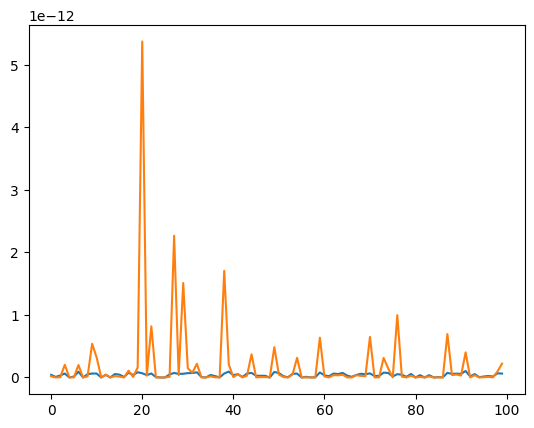

In [100]:
plt.plot(ice_n[:100])
plt.plot(atm_n[:100])
plt.set
plt.show()

### Plot the score histograms for all models

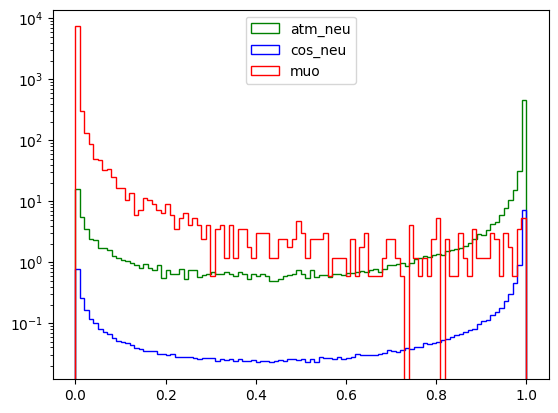

In [57]:
#xgboost 1-1 analogy
prob_eval_n = model_xgb.predict_proba(df_n_eval)
prob_eval_m = model_xgb.predict_proba(df_m_eval)
n1, x1, _ = plt.hist(prob_eval_n[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2, x2, _ =plt.hist(prob_eval_n[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3, x3, _ =plt.hist(prob_eval_m[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.savefig('xgb_1-1.png')
plt.show()

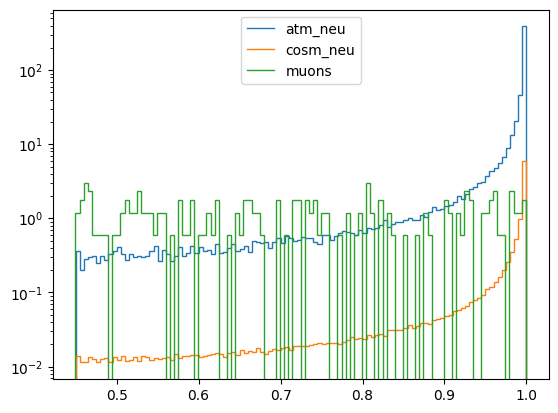

In [265]:
plt.stairs(n1[90:], x1[90:], label='atm_neu')
plt.stairs(n2[90:], x2[90:], label='cosm_neu')
plt.stairs(n3[90:], x3[90:], label='muons')
plt.yscale('log')
plt.legend(loc='upper center')

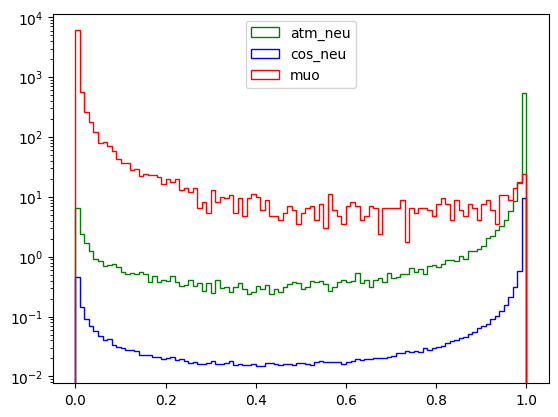

In [58]:
#xgboost 10-1 analogy
prob_eval_n = model_xgb_.predict_proba(df_n_eval)
prob_eval_m = model_xgb_.predict_proba(df_m_eval)
n1_, x1_, _ = plt.hist(prob_eval_n[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_, x2_, _ =plt.hist(prob_eval_n[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_, x3_, _ =plt.hist(prob_eval_m[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.savefig('xgb_10-1.png')
plt.show()

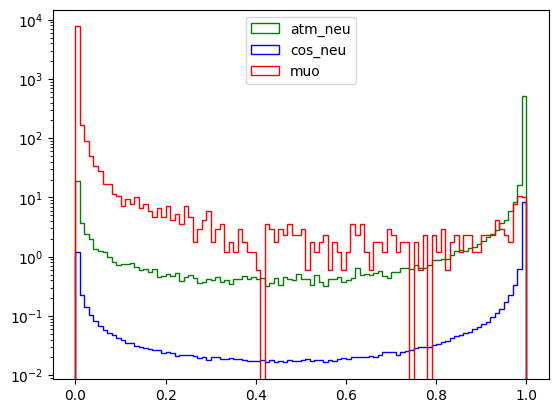

In [59]:
#xgboost scaled training
prob_eval_n = model_xgb_s.predict_proba(df_n_eval)
prob_eval_m = model_xgb_s.predict_proba(df_m_eval)
n1_s, x1_s, _ = plt.hist(prob_eval_n[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_s, x2_s, _ =plt.hist(prob_eval_n[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_s, x3_s, _ =plt.hist(prob_eval_m[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
#plt.savefig('xgb_scaled.png')
plt.show()

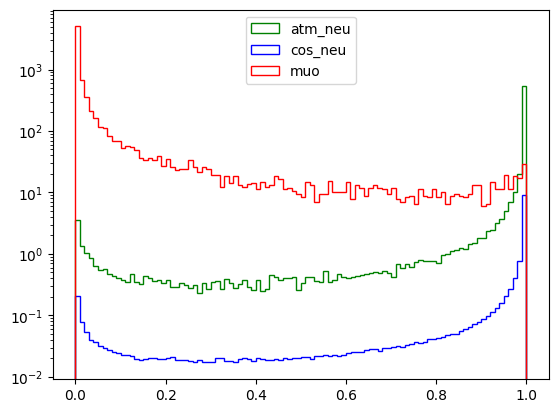

In [60]:
#xgboost 10 mini
prob_eval_n = sum([m.predict_proba(df_n_eval) for m in model_xgb_s_m])/10
prob_eval_m = sum([m.predict_proba(df_m_eval) for m in model_xgb_s_m])/10
n1_s_m, x1_s_m, _ = plt.hist(prob_eval_n[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_s_m, x2_s_m, _ =plt.hist(prob_eval_n[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_s_m, x3_s_m, _ =plt.hist(prob_eval_m[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.savefig('xgb_10_mini.png')
plt.show()

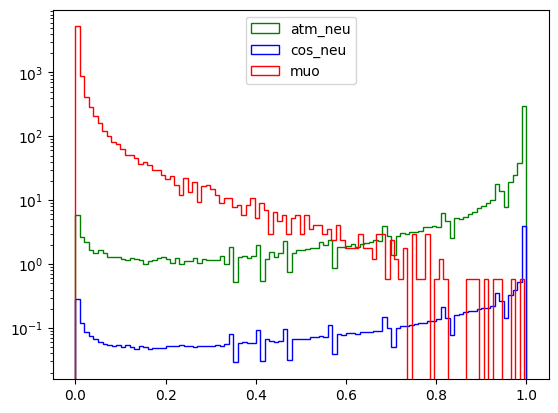

In [61]:
#random forest
prob_eval_n = model_rnd.predict_proba(df_n_eval)
prob_eval_m = model_rnd.predict_proba(df_m_eval)
n1_r, x1_r, _ = plt.hist(prob_eval_n[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_r, x2_r, _ =plt.hist(prob_eval_n[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_r, x3_r, _ =plt.hist(prob_eval_m[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.savefig('rnd_last.png')
plt.show()

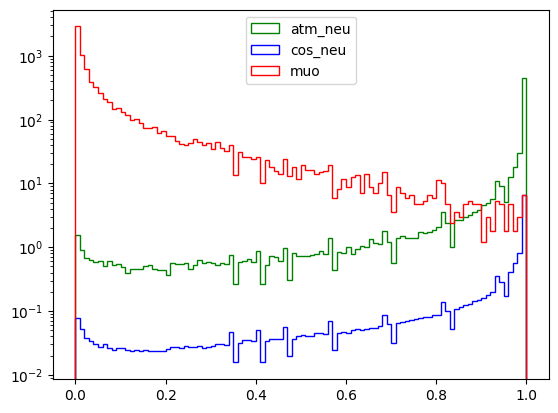

In [62]:
#random forest 10
prob_eval_n_ = model_rnd_.predict_proba(df_n_eval)
prob_eval_m_ = model_rnd_.predict_proba(df_m_eval)
n1_r_, x1_r_, _ = plt.hist(prob_eval_n_[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_r_, x2_r_, _ =plt.hist(prob_eval_n_[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_r_, x3_r_, _ =plt.hist(prob_eval_m_[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m_[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
#plt.savefig('rnd10_last.png')
plt.show()

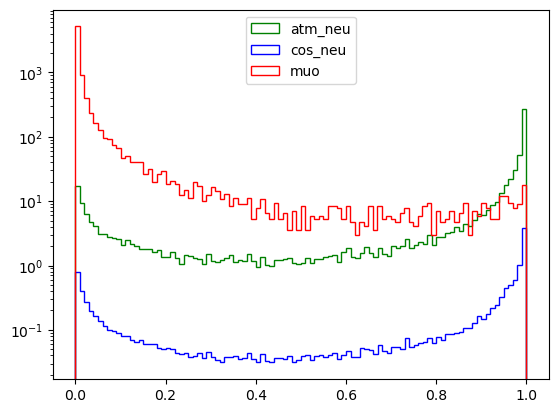

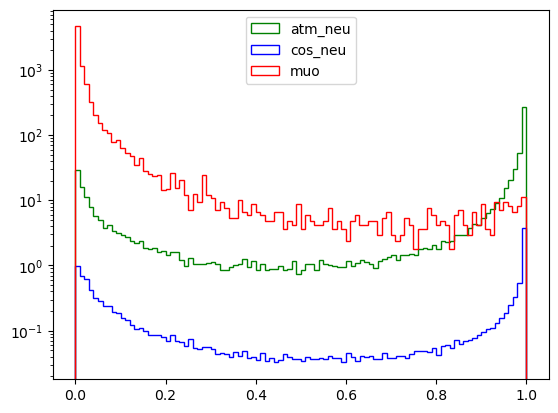

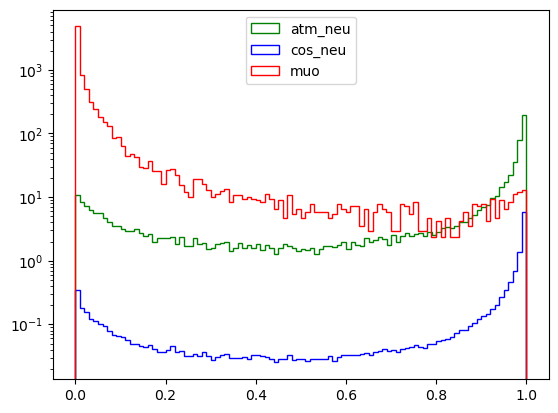

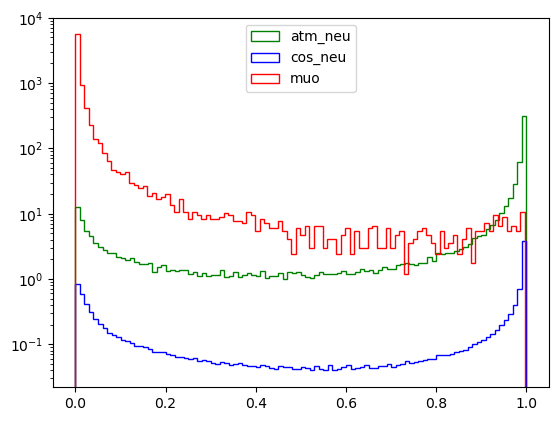

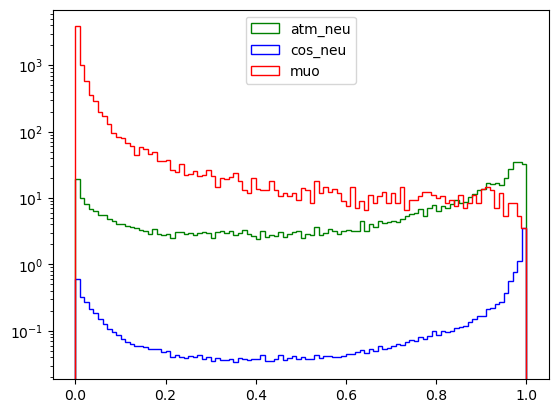

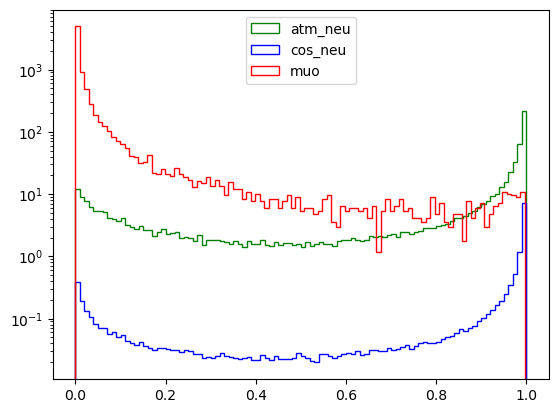

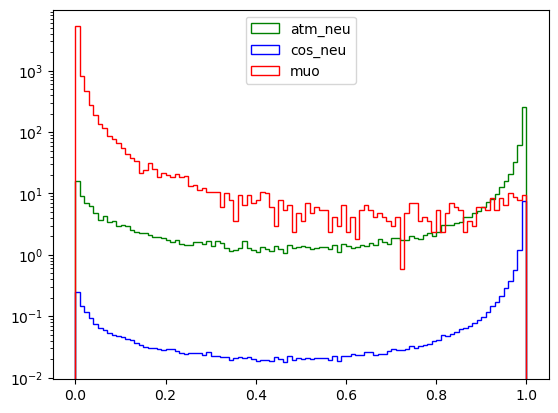

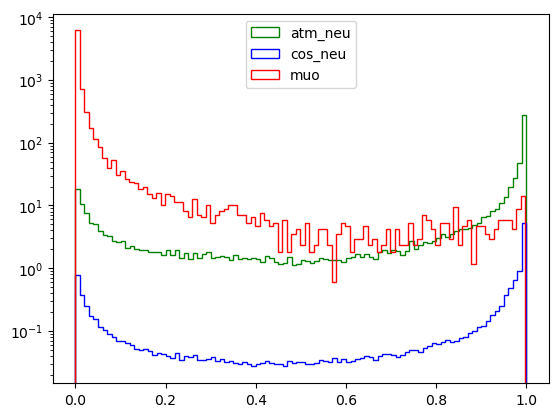

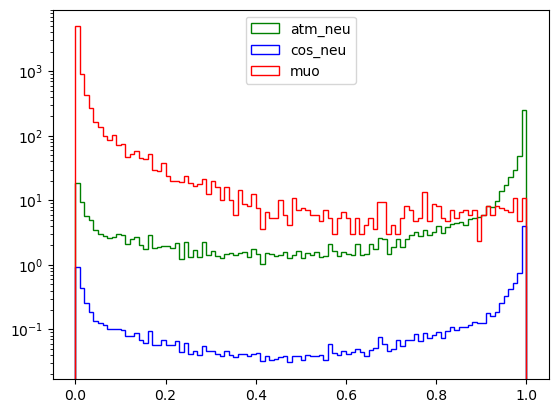

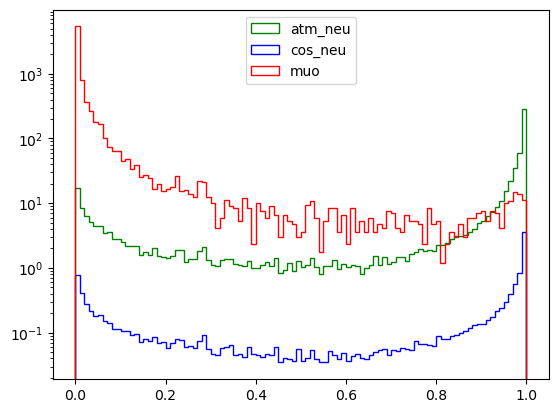

In [49]:
#xgboost 7 vars
import warnings 
warnings.filterwarnings('ignore')
for m, v in zip(model_xgb_t, vrs_t):
    prob_eval_n = m.predict_proba(df_n_eval[v])
    prob_eval_m = m.predict_proba(df_m_eval[v])
    n1_t, x1_t, _ = plt.hist(prob_eval_n[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
    n2_t, x2_t, _ =plt.hist(prob_eval_n[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
    n3_t, x3_t, _ =plt.hist(prob_eval_m[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
    #n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
    #plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
    plt.legend(loc='upper center')
    #plt.savefig('xgb_1-1.png')
    plt.show()

In [ ]:
#SVM
prob_eval_n_svm = model_svm.predict_proba(df_n_eval)
prob_eval_m_svm = model_svm.predict_proba(df_m_eval)
n1_svm, x1_svm, _ = plt.hist(prob_eval_n_svm[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_svm, x2_svm, _ =plt.hist(prob_eval_n_svm[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_svm, x3_svm, _ =plt.hist(prob_eval_m_svm[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m_svm[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.savefig('svm.png')
plt.show()

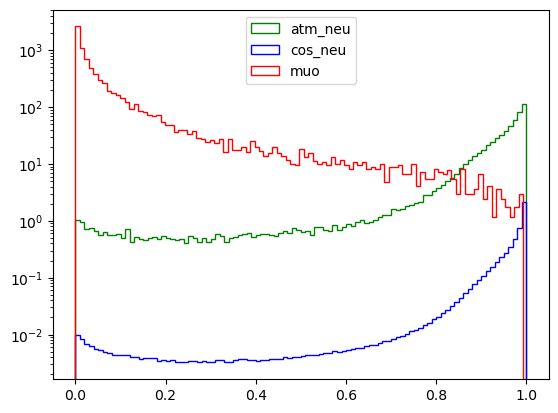

In [33]:
### ada boost
prob_eval_ad = model_ada.predict_proba(df_eval)
prob_eval_m_ad = model_ada.predict_proba(df_m_eval)
n1_ad, x1_ad, _ = plt.hist(prob_eval_ad[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_ad, x2_ad, _ =plt.hist(prob_eval_ad[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_ad, x3_ad, _ =plt.hist(prob_eval_m_ad[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m_ad[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
#plt.savefig('ada_boost.png')
plt.show()

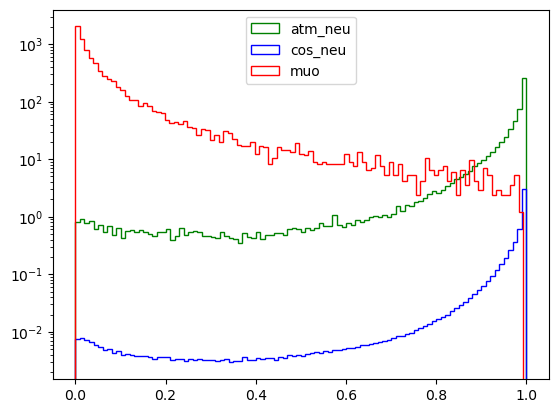

In [21]:
### ada boost new ds
prob_eval_ad = model_ada.predict_proba(df_n_eval)
prob_eval_m_ad = model_ada.predict_proba(df_m_eval)
n1_ad, x1_ad, _ = plt.hist(prob_eval_ad[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_ad, x2_ad, _ =plt.hist(prob_eval_ad[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_ad, x3_ad, _ =plt.hist(prob_eval_m_ad[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m_ad[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
#plt.savefig('ada_boost.png')
plt.show()

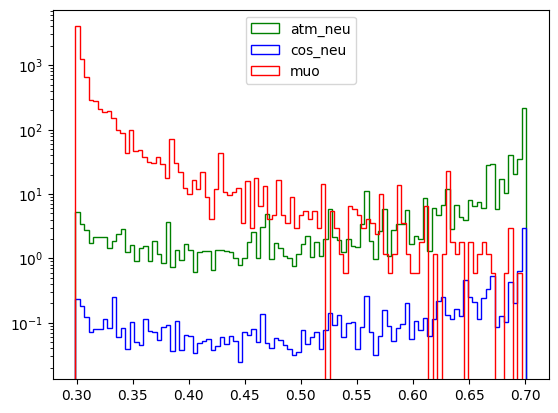

In [63]:
prob_eval_n_ad = model_ctb.predict_proba(df_n_eval)
prob_eval_m_ad = model_ctb.predict_proba(df_m_eval)
n1_ctb, x1_ctb, _ = plt.hist(prob_eval_n_ad[:,1], 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_ctb, x2_ctb, _ =plt.hist(prob_eval_n_ad[:,1], 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_ctb, x3_ctb, _ =plt.hist(prob_eval_m_ad[:,1], 100, log=True, weights=[muons_scale]*prob_eval_m_ad[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.savefig('ctb_boost.png')
plt.show()

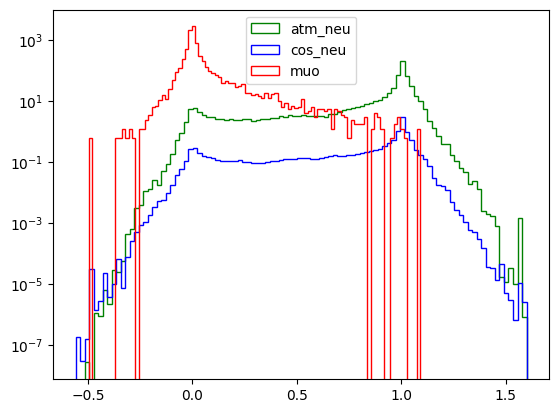

In [75]:
prob_eval_n_xgbr = model_xgbr.predict(df_n_eval)
prob_eval_m_xgbr = model_xgbr.predict(df_m_eval)
n1_xgbr, x1_xgbr, _ = plt.hist(prob_eval_n_xgbr, 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_xgbr, x2_xgbr, _ =plt.hist(prob_eval_n_xgbr, 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_xgbr, x3_xgbr, _ =plt.hist(prob_eval_m_xgbr, 100, log=True, weights=[muons_scale]*prob_eval_m_xgbr.shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i], 200, log=True, weights=[data_scale]*prob_data[i].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.savefig('xgbr.png')
plt.show()

### Plot some metrics as a function of the cut for every model

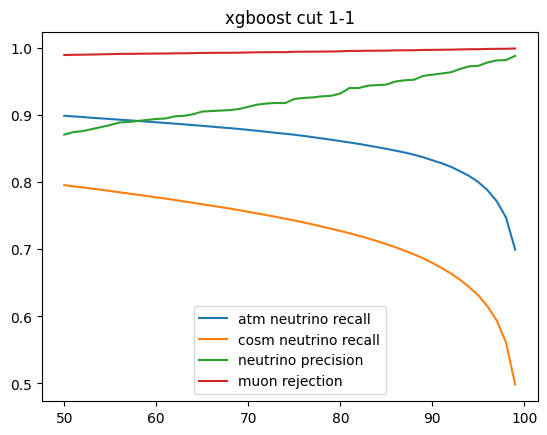

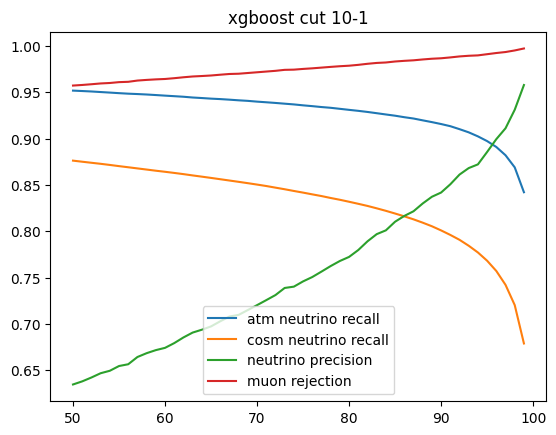

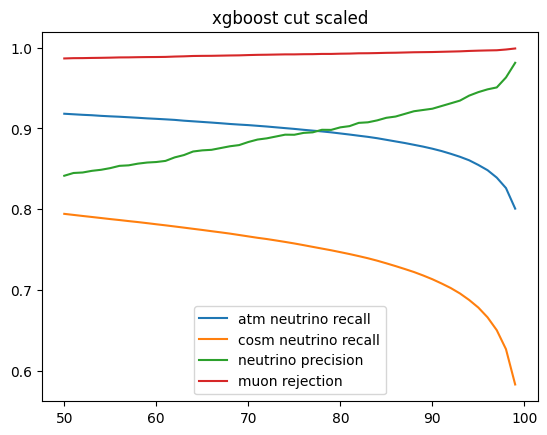

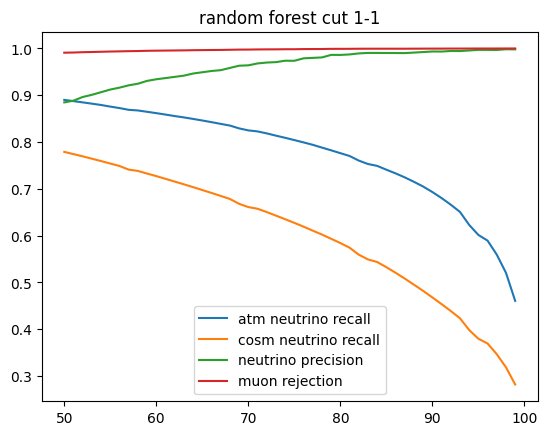

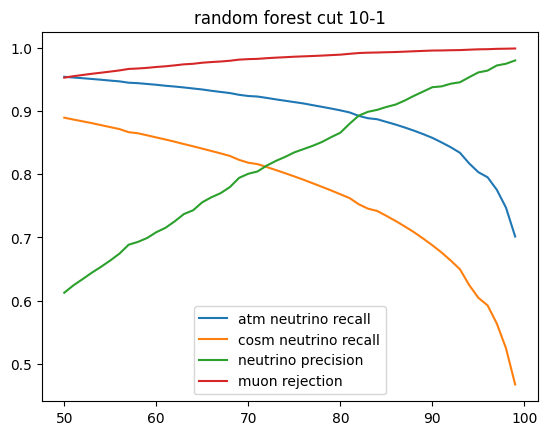

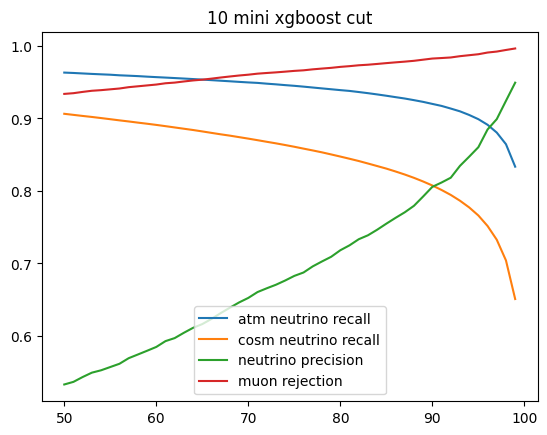

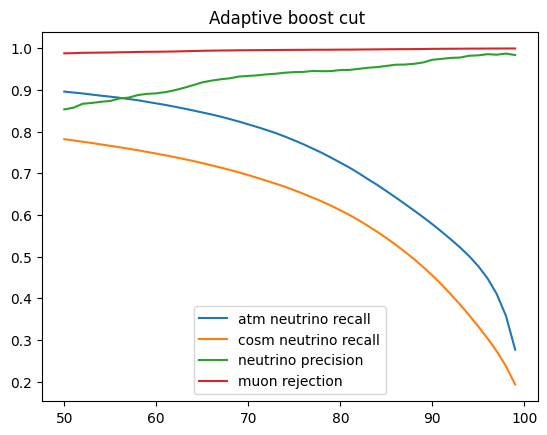

In [83]:
cut = [i for i in range(50, 100)]
atm = [sum(n1[c:])/( sum(n1)) for c in cut]
cosm = [sum(n2[c:])/( sum(n2))for c in cut]
truep = [sum(n1[c:] + n2[c:])/ sum(n1[c:] + n2[c:] + n3[c:]) for c in cut]
rejm = [1 - sum(n3[c:])/ sum(n3) for c in cut]
truepc = [sum(n2[c:])/ sum(n1[c:] + n2[c:] + n3[c:]) for c in cut]
plt.plot(cut, atm, label='atm neutrino recall')
plt.plot(cut, cosm,  label='cosm neutrino recall')
plt.plot(cut, truep, label='neutrino precision')
#plt.plot(cut, truepc, label='cosm neutrino precision')
plt.plot(cut, rejm, label='muon rejection')
plt.legend(loc='lower center')
plt.title('xgboost cut 1-1')
plt.show()

atm_ = [sum(n1_[c:])/( sum(n1_)) for c in cut]
cosm_ = [sum(n2_[c:])/( sum(n2_))for c in cut]
truep_ = [sum(n1_[c:] + n2_[c:])/ sum(n1_[c:] + n2_[c:] + n3_[c:]) for c in cut]
truepc_ = [sum(n2_[c:])/ sum(n1_[c:] + n2_[c:] + n3_[c:]) for c in cut]
rejm_= [1 - sum(n3_[c:])/ sum(n3_) for c in cut]
plt.plot(cut, atm_, label='atm neutrino recall')
plt.plot(cut, cosm_,  label='cosm neutrino recall')
plt.plot(cut, truep_, label='neutrino precision')
#plt.plot(cut, truepc_, label='cosm neutrino precision')
plt.plot(cut, rejm_, label='muon rejection')
plt.legend(loc='lower center')
plt.title('xgboost cut 10-1')
plt.show()

atm_s = [sum(n1_s[c:])/( sum(n1_s)) for c in cut]
cosm_s = [sum(n2_s[c:])/( sum(n2_s))for c in cut]
truep_s = [sum(n1_s[c:] + n2_s[c:])/ sum(n1_s[c:] + n2_s[c:] + n3_s[c:]) for c in cut]
truepc_s = [sum(n2_s[c:])/ sum(n1_s[c:] + n2_s[c:] + n3_s[c:]) for c in cut]
rejm_s = [1 - sum(n3_s[c:])/ sum(n3_s) for c in cut]
plt.plot(cut, atm_s, label='atm neutrino recall')
plt.plot(cut, cosm_s,  label='cosm neutrino recall')
plt.plot(cut, truep_s, label='neutrino precision')
#plt.plot(cut, truepc_s, label='cosm neutrino precision')
plt.plot(cut, rejm_s, label='muon rejection')
plt.legend(loc='lower center')
plt.title('xgboost cut scaled')
plt.show()

atm_r = [sum(n1_r[c:])/( sum(n1_r)) for c in cut]
cosm_r = [sum(n2_r[c:])/( sum(n2_r))for c in cut]
truep_r = [sum(n1_r[c:] + n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
truepc_r= [sum(n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
rejm_r = [1 - sum(n3_r[c:])/ sum(n3_r) for c in cut]
plt.plot(cut, atm_r, label='atm neutrino recall')
plt.plot(cut, cosm_r,  label='cosm neutrino recall')
plt.plot(cut, truep_r, label='neutrino precision')
#plt.plot(cut, truepc_r, label='cosm neutrino precision')
plt.plot(cut, rejm_r, label='muon rejection')
plt.legend(loc='lower center')
plt.title('random forest cut 1-1')
plt.show()


atm_r_ = [sum(n1_r_[c:])/( sum(n1_r_)) for c in cut]
cosm_r_ = [sum(n2_r_[c:])/( sum(n2_r_))for c in cut]
truep_r_ = [sum(n1_r_[c:] + n2_r[c:])/ sum(n1_r_[c:] + n2_r_[c:] + n3_r_[c:]) for c in cut]
truepc_r_ = [sum(n2_r_[c:])/ sum(n1_r_[c:] + n2_r_[c:] + n3_r_[c:]) for c in cut]
rejm_r_ = [1 - sum(n3_r_[c:])/ sum(n3_r_) for c in cut]
plt.plot(cut, atm_r_, label='atm neutrino recall')
plt.plot(cut, cosm_r_,  label='cosm neutrino recall')
plt.plot(cut, truep_r_, label='neutrino precision')
#plt.plot(cut, truepc_r_, label='cosm neutrino precision')
plt.plot(cut, rejm_r_, label='muon rejection')
plt.legend(loc='lower center')
plt.title('random forest cut 10-1')
plt.show()

atm_s_m = [sum(n1_s_m[c:])/( sum(n1_s_m)) for c in cut]
cosm_s_m = [sum(n2_s_m[c:])/( sum(n2_s_m))for c in cut]
truep_s_m = [sum(n1_s_m[c:] + n2_s_m[c:])/ sum(n1_s_m[c:] + n2_s_m[c:] + n3_s_m[c:]) for c in cut]
truepc_s_m = [sum(n2_s_m[c:])/ sum(n1_s_m[c:] + n2_s_m[c:] + n3_s_m[c:]) for c in cut]
rejm_s_m= [1 - sum(n3_s_m[c:])/ sum(n3_s_m) for c in cut]
plt.plot(cut, atm_s_m, label='atm neutrino recall')
plt.plot(cut, cosm_s_m,  label='cosm neutrino recall')
plt.plot(cut, truep_s_m, label='neutrino precision')
#plt.plot(cut, truepc_s_m, label='cosm neutrino precision')
plt.plot(cut, rejm_s_m, label='muon rejection')
plt.legend(loc='lower center')
plt.title('10 mini xgboost cut')
plt.show()

atm_ada = [sum(n1_ad[100+c:])/( sum(n1_ad)) for c in cut]
cosm_ada = [sum(n2_ad[100+c:])/( sum(n2_ad))for c in cut]
truep_ada = [sum(n1_ad[100+c:] + n2_ad[100+c:])/ sum(n1_ad[100 + c:] + n2_ad[100 + c:] + n3_ad[100+c:]) for c in cut]
truepc_ada = [sum(n2_ad[100+c:])/ sum(n1_ad[100+c:] + n2_ad[100+c:] + n3_ad[100+c:]) for c in cut]
rejm_ada= [1 - sum(n3_ad[100+c:])/ sum(n3_ad) for c in cut]
plt.plot(cut, atm_ada, label='atm neutrino recall')
plt.plot(cut, cosm_ada,  label='cosm neutrino recall')
plt.plot(cut, truep_ada, label='neutrino precision')
plt.plot(cut, rejm_ada, label='muon rejection')
#plt.plot(cut, truepc_ada, label='cosm neutrino precision')
plt.legend(loc='lower center')
plt.title('Adaptive boost cut ')
plt.show()



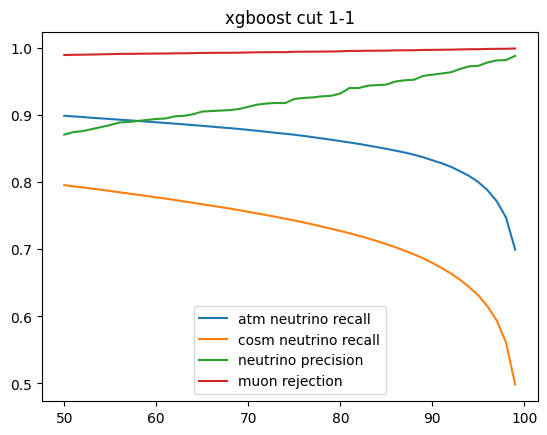

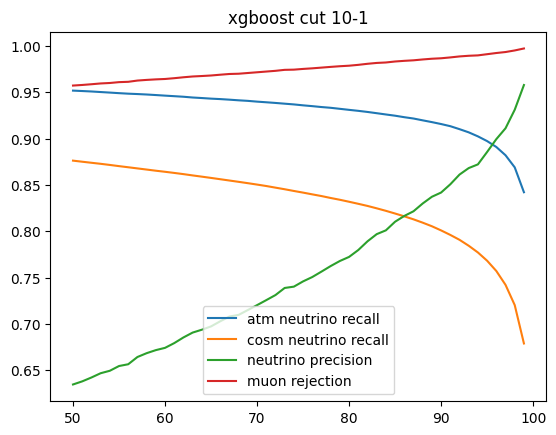

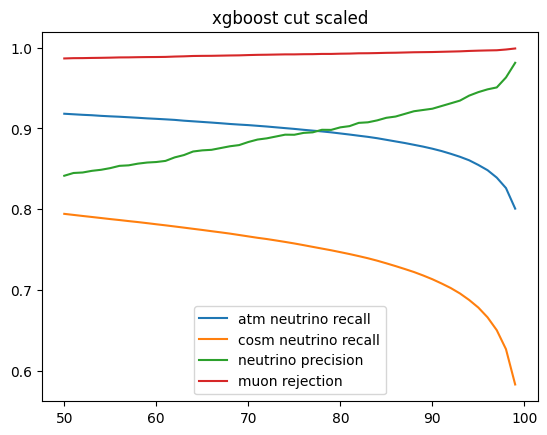

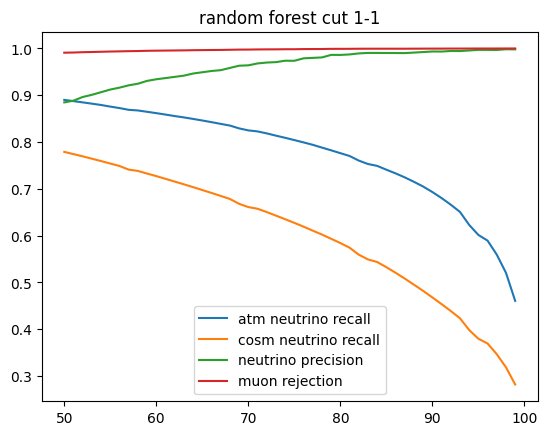

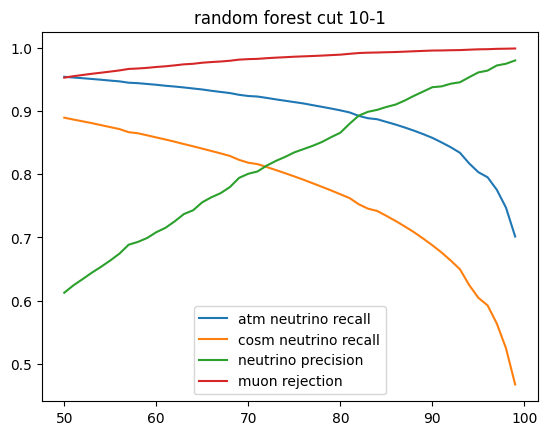

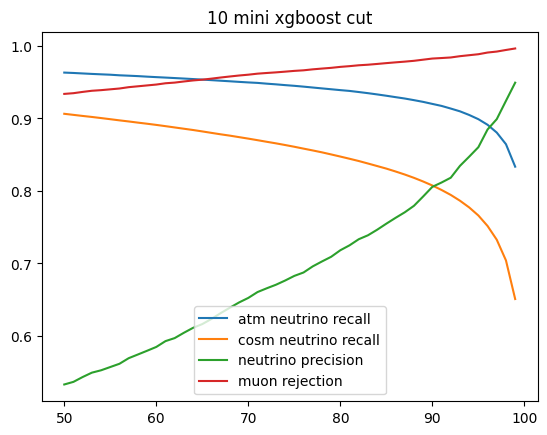

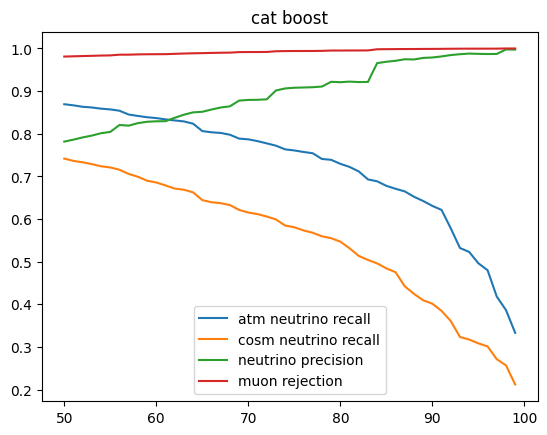

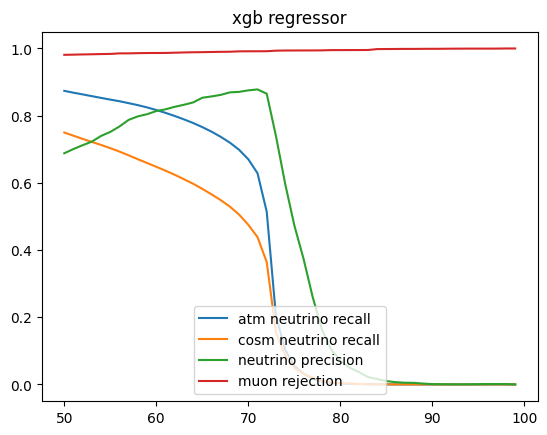

In [76]:
cut = [i for i in range(50, 100)]
atm = [sum(n1[c:])/( sum(n1)) for c in cut]
cosm = [sum(n2[c:])/( sum(n2))for c in cut]
truep = [sum(n1[c:] + n2[c:])/ sum(n1[c:] + n2[c:] + n3[c:]) for c in cut]
rejm = [1 - sum(n3[c:])/ sum(n3) for c in cut]
truepc = [sum(n2[c:])/ sum(n1[c:] + n2[c:] + n3[c:]) for c in cut]
plt.plot(cut, atm, label='atm neutrino recall')
plt.plot(cut, cosm,  label='cosm neutrino recall')
plt.plot(cut, truep, label='neutrino precision')
#plt.plot(cut, truepc, label='cosm neutrino precision')
plt.plot(cut, rejm, label='muon rejection')
plt.legend(loc='lower center')
plt.title('xgboost cut 1-1')
plt.show()

atm_ = [sum(n1_[c:])/( sum(n1_)) for c in cut]
cosm_ = [sum(n2_[c:])/( sum(n2_))for c in cut]
truep_ = [sum(n1_[c:] + n2_[c:])/ sum(n1_[c:] + n2_[c:] + n3_[c:]) for c in cut]
truepc_ = [sum(n2_[c:])/ sum(n1_[c:] + n2_[c:] + n3_[c:]) for c in cut]
rejm_= [1 - sum(n3_[c:])/ sum(n3_) for c in cut]
plt.plot(cut, atm_, label='atm neutrino recall')
plt.plot(cut, cosm_,  label='cosm neutrino recall')
plt.plot(cut, truep_, label='neutrino precision')
#plt.plot(cut, truepc_, label='cosm neutrino precision')
plt.plot(cut, rejm_, label='muon rejection')
plt.legend(loc='lower center')
plt.title('xgboost cut 10-1')
plt.show()

atm_s = [sum(n1_s[c:])/( sum(n1_s)) for c in cut]
cosm_s = [sum(n2_s[c:])/( sum(n2_s))for c in cut]
truep_s = [sum(n1_s[c:] + n2_s[c:])/ sum(n1_s[c:] + n2_s[c:] + n3_s[c:]) for c in cut]
truepc_s = [sum(n2_s[c:])/ sum(n1_s[c:] + n2_s[c:] + n3_s[c:]) for c in cut]
rejm_s = [1 - sum(n3_s[c:])/ sum(n3_s) for c in cut]
plt.plot(cut, atm_s, label='atm neutrino recall')
plt.plot(cut, cosm_s,  label='cosm neutrino recall')
plt.plot(cut, truep_s, label='neutrino precision')
#plt.plot(cut, truepc_s, label='cosm neutrino precision')
plt.plot(cut, rejm_s, label='muon rejection')
plt.legend(loc='lower center')
plt.title('xgboost cut scaled')
plt.show()

atm_r = [sum(n1_r[c:])/( sum(n1_r)) for c in cut]
cosm_r = [sum(n2_r[c:])/( sum(n2_r))for c in cut]
truep_r = [sum(n1_r[c:] + n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
truepc_r= [sum(n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
rejm_r = [1 - sum(n3_r[c:])/ sum(n3_r) for c in cut]
plt.plot(cut, atm_r, label='atm neutrino recall')
plt.plot(cut, cosm_r,  label='cosm neutrino recall')
plt.plot(cut, truep_r, label='neutrino precision')
#plt.plot(cut, truepc_r, label='cosm neutrino precision')
plt.plot(cut, rejm_r, label='muon rejection')
plt.legend(loc='lower center')
plt.title('random forest cut 1-1')
plt.show()


atm_r_ = [sum(n1_r_[c:])/( sum(n1_r_)) for c in cut]
cosm_r_ = [sum(n2_r_[c:])/( sum(n2_r_))for c in cut]
truep_r_ = [sum(n1_r_[c:] + n2_r[c:])/ sum(n1_r_[c:] + n2_r_[c:] + n3_r_[c:]) for c in cut]
truepc_r_ = [sum(n2_r_[c:])/ sum(n1_r_[c:] + n2_r_[c:] + n3_r_[c:]) for c in cut]
rejm_r_ = [1 - sum(n3_r_[c:])/ sum(n3_r_) for c in cut]
plt.plot(cut, atm_r_, label='atm neutrino recall')
plt.plot(cut, cosm_r_,  label='cosm neutrino recall')
plt.plot(cut, truep_r_, label='neutrino precision')
#plt.plot(cut, truepc_r_, label='cosm neutrino precision')
plt.plot(cut, rejm_r_, label='muon rejection')
plt.legend(loc='lower center')
plt.title('random forest cut 10-1')
plt.show()

atm_s_m = [sum(n1_s_m[c:])/( sum(n1_s_m)) for c in cut]
cosm_s_m = [sum(n2_s_m[c:])/( sum(n2_s_m))for c in cut]
truep_s_m = [sum(n1_s_m[c:] + n2_s_m[c:])/ sum(n1_s_m[c:] + n2_s_m[c:] + n3_s_m[c:]) for c in cut]
truepc_s_m = [sum(n2_s_m[c:])/ sum(n1_s_m[c:] + n2_s_m[c:] + n3_s_m[c:]) for c in cut]
rejm_s_m= [1 - sum(n3_s_m[c:])/ sum(n3_s_m) for c in cut]
plt.plot(cut, atm_s_m, label='atm neutrino recall')
plt.plot(cut, cosm_s_m,  label='cosm neutrino recall')
plt.plot(cut, truep_s_m, label='neutrino precision')
#plt.plot(cut, truepc_s_m, label='cosm neutrino precision')
plt.plot(cut, rejm_s_m, label='muon rejection')
plt.legend(loc='lower center')
plt.title('10 mini xgboost cut')
plt.show()

atm_ctb = [sum(n1_ctb[c:])/( sum(n1_ctb)) for c in cut]
cosm_ctb = [sum(n2_ctb[c:])/( sum(n2_ctb))for c in cut]
truep_ctb = [sum(n1_ctb[c:] + n2_ctb[c:])/ sum(n1_ctb[c:] + n2_ctb[c:] + n3_ctb[c:]) for c in cut]
truepc_ctb= [sum(n2_ctb[c:])/ sum(n1_ctb[c:] + n2_ctb[c:] + n3_ctb[c:]) for c in cut]
rejm_ctb = [1 - sum(n3_ctb[c:])/ sum(n3_ctb) for c in cut]
plt.plot(cut, atm_ctb, label='atm neutrino recall')
plt.plot(cut, cosm_ctb,  label='cosm neutrino recall')
plt.plot(cut, truep_ctb, label='neutrino precision')
#plt.plot(cut, truepc_ctb, label='cosm neutrino precision')
plt.plot(cut, rejm_ctb, label='muon rejection')
plt.legend(loc='lower center')
plt.title('cat boost')
plt.show()

atm_xgbr = [sum(n1_xgbr[c:])/( sum(n1_xgbr)) for c in cut]
cosm_xgbr = [sum(n2_xgbr[c:])/( sum(n2_xgbr))for c in cut]
truep_xgbr = [sum(n1_xgbr[c:] + n2_xgbr[c:])/ sum(n1_xgbr[c:] + n2_xgbr[c:] + n3_xgbr[c:]) for c in cut]
truepc_xgbr= [sum(n2_xgbr[c:])/ sum(n1_xgbr[c:] + n2_xgbr[c:] + n3_xgbr[c:]) for c in cut]
rejm_xgbr = [1 - sum(n3_xgbr[c:])/ sum(n3_xgbr) for c in cut]
plt.plot(cut, atm_xgbr, label='atm neutrino recall')
plt.plot(cut, cosm_xgbr,  label='cosm neutrino recall')
plt.plot(cut, truep_xgbr, label='neutrino precision')
#plt.plot(cut, truepc_xgbr, label='cosm neutrino precision')
plt.plot(cut, rejm_ctb, label='muon rejection')
plt.legend(loc='lower center')
plt.title('xgb regressor')
plt.show()




## Back to TMVA
Reproduce the existing TMVA model for direct comparisons

In [22]:
import ROOT as R
from ROOT import TMVA

# ROOT and TMVA require an open file to store things
# as they go along
outfile = R.TFile('/tmp/tmva_output.root', 'recreate')

factory = TMVA.Factory("TMVAClassification", outfile, "AnalysisType=Classification")
dataloader = TMVA.DataLoader("dataset")
for n in range(15):
    dataloader.AddVariable("f%i"%n, "F")

for y,row in zip(y_train_, X_train_.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)

    if y > 0:
        dataloader.AddSignalTrainingEvent(a)
    else:        
        dataloader.AddBackgroundTrainingEvent(a)
        
for y,row in zip(y_test_, X_test_.iterrows()):
    a = R.vector('double')() # instantiate a std::vector<double>
    for r in row[1]:
        a.push_back(r)
        
    if y > 0:
        dataloader.AddSignalTestEvent(a)
    else:        
        dataloader.AddBackgroundTestEvent(a)

dataloader.PrepareTrainingAndTestTree(R.TCut("1"), "SplitMode=Random:NormMode=NumEvents")

/home/orestis/miniconda3/envs/nccr/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/orestis/miniconda3/envs/nccr/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/orestis/miniconda3/envs/nccr/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/orestis/miniconda3/envs/nccr/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/orestis/miniconda3/envs/nccr/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allocator_args.h" [optional] {
   

Welcome to JupyROOT 6.28/04
<HEADER> DataSetInfo              : [dataset] : Added class "Signal"
<HEADER> DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree TrainAssignTree_Signal of type Signal with 41597 events
                         : Add Tree TestAssignTree_Signal of type Signal with 10393 events
                         : Add Tree TrainAssignTree_Background of type Background with 4154 events
                         : Add Tree TestAssignTree_Background of type Background with 1045 events
                         : Dataset[dataset] : Class index : 0  name : Signal
                         : Dataset[dataset] : Class index : 1  name : Background


In [23]:
factory.BookMethod(dataloader, TMVA.Types.kBDT, "BDT", 
                   "NTrees=1200:MinNodeSize=1.0:BoostType=AdaBoost:AdaBoostBeta=0.02:SeparationType=GiniIndex:nCuts=14:MaxDepth=6"
                   )
factory.TrainAllMethods()

<HEADER> Factory                  : Booking method: BDT
                         : 
                         : Rebuilding Dataset dataset
                         : Building event vectors for type 0 Signal
                         : Dataset[dataset] :  create input formulas for tree TrainAssignTree_Signal
                         : Building event vectors for type 1 Signal
                         : Dataset[dataset] :  create input formulas for tree TestAssignTree_Signal
                         : Building event vectors for type 0 Background
                         : Dataset[dataset] :  create input formulas for tree TrainAssignTree_Background
                         : Building event vectors for type 1 Background
                         : Dataset[dataset] :  create input formulas for tree TestAssignTree_Background
<HEADER> DataSetFactory           : [dataset] : Number of events in input trees
                         : Dataset[dataset] :     Signal     requirement: "1"
              

0%, time left: unknown
6%, time left: 73 sec
12%, time left: 65 sec
18%, time left: 60 sec
25%, time left: 53 sec
31%, time left: 48 sec
37%, time left: 44 sec
43%, time left: 39 sec
50%, time left: 34 sec
56%, time left: 29 sec
62%, time left: 25 sec
68%, time left: 21 sec
75%, time left: 17 sec
81%, time left: 12 sec
87%, time left: 8 sec
93%, time left: 4 sec
0%, time left: unknown
6%, time left: 10 sec
12%, time left: 8 sec
18%, time left: 7 sec
25%, time left: 7 sec
31%, time left: 6 sec
37%, time left: 6 sec
43%, time left: 5 sec
50%, time left: 4 sec
56%, time left: 4 sec
62%, time left: 3 sec
68%, time left: 2 sec
75%, time left: 2 sec
81%, time left: 1 sec
87%, time left: 1 sec
93%, time left: 0 sec


In [24]:
from array import array
from sklearn.metrics import classification_report, roc_auc_score
reader = TMVA.Reader()
for n in range(15):
    a = array("f", [0.])
    #a = R.vector('double')()
    reader.AddVariable("f%i"%n, a)
    
reader.BookMVA("BDT", "dataset/weights/TMVAClassification_BDT.weights.xml")


y_predicted = []
decision_val = []
for row in X_test_.iterrows():
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
        
    value = reader.EvaluateMVA(a, "BDT")
    decision_val.append(value)
    if value > 0:
        y_predicted.append(+1)
    else:
        y_predicted.append(0)
        
print(classification_report(y_test_, y_predicted, target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score(y_test_, y_predicted)))

              precision    recall  f1-score   support

  background       0.92      0.99      0.95      1045
      signal       1.00      0.99      1.00     10393

    accuracy                           0.99     11438
   macro avg       0.96      0.99      0.97     11438
weighted avg       0.99      0.99      0.99     11438

Area under ROC curve: 0.9913
                         : Booking "BDT" of type "BDT" from dataset/weights/TMVAClassification_BDT.weights.xml.
                         : Reading weight file: dataset/weights/TMVAClassification_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT" of type: "BDT"


In [ ]:
y_predicted = []
decision_val = []
for row in df_n_eval.iterrows():
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
        
    value = reader.EvaluateMVA(a, "BDT")
    decision_val.append(value)
    if value > 0:
        y_predicted.append(+1)
    else:
        y_predicted.append(0)
        
print(classification_report([1]*df_n_eval.shape[0], y_predicted, target_names=["background", "signal"]))
print("Area under ROC curve: %.4f"%(roc_auc_score([1]*df_n_eval.shape[0], y_predicted)))

In [83]:
n_val = []
m_val = []
for k, row in enumerate(df_n_eval.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
       a.push_back(r)
    value = reader.EvaluateMVA(a, "BDT")
    n_val.append(value)
    #print(value)
    if k%100000==0:
        print(k%100000)
for k, row in enumerate(df_m_eval.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
    
    value = reader.EvaluateMVA(a, "BDT")
    m_val.append(value)
    #print(value)
    if k%100000==0:
        print(k%100000)

0


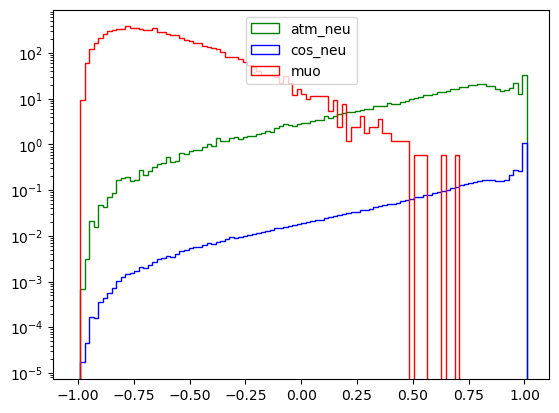

In [99]:
n1_r, x1_r, _ = plt.hist(n_val, 100, range=(-1.01,1.01), log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_r, x2_r, _ =plt.hist(n_val, 100, range=(-1.01,1.01), log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_r, x3_r, _ =plt.hist(m_val, 100, range=(-1.01,1.01), log=True, weights=[muons_scale]*len(m_val), histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
#plt.savefig('rnd_last.png')
plt.show()

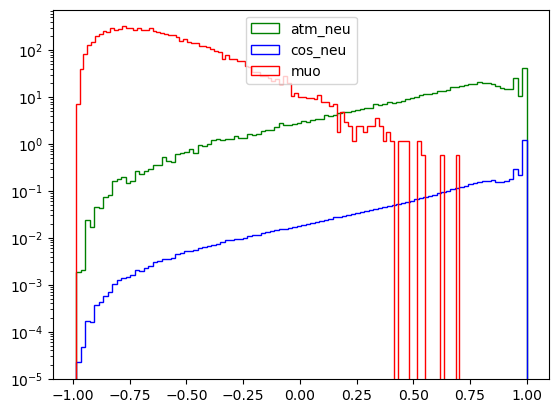

In [31]:
n1_r, x1_r, _ = plt.hist(n_val, 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_r, x2_r, _ =plt.hist(n_val, 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3_r, x3_r, _ =plt.hist(m_val, 100, log=True, weights=[muons_scale]*len(m_val), histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
#plt.savefig('rnd_last.png')
plt.show()

In [42]:
np.save('probs_tmva_n', n_val, allow_pickle=True)
np.save('probs_tmva_m', m_val, allow_pickle=True)
np.save('probs_ada_n', prob_eval_n_ad, allow_pickle=True)
np.save('probs_ada_m', prob_eval_m_ad, allow_pickle=True)

In [3]:
n_val = np.load('probs_tmva_n.npy')
m_val = np.load('probs_tmva_m.npy')
prob_eval_n_ad = np.load('probs_ada_n.npy')
prob_eval_m_ad = np.load('probs_ada_m.npy')

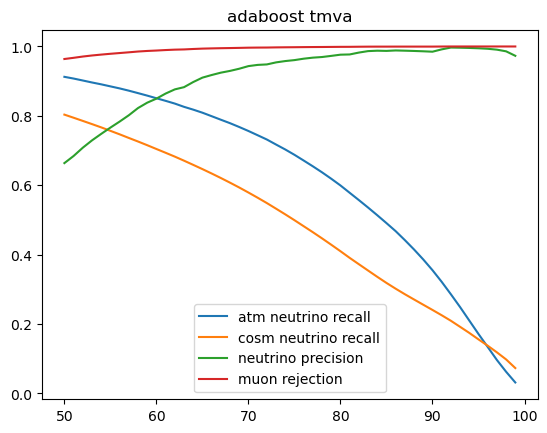

In [18]:
cut = [i for i in range(50, 100)]
atm = [sum(n1_r[c:])/( sum(n1_r)) for c in cut]
cosm = [sum(n2_r[c:])/( sum(n2_r))for c in cut]
truep = [sum(n1_r[c:] + n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
rejm = [1 - sum(n3_r[c:])/ sum(n3_r) for c in cut]
truepc = [sum(n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
plt.plot(cut, atm, label='atm neutrino recall')
plt.plot(cut, cosm,  label='cosm neutrino recall')
plt.plot(cut, truep, label='neutrino precision')
#plt.plot(cut, truepc, label='cosm neutrino precision')
plt.plot(cut, rejm, label='muon rejection')
plt.legend(loc='lower center')
plt.title('adaboost tmva')
plt.show()

Some histograms to understand relation between energy and BDT scores

In [ ]:
plt.plot(np.array(Tr_n['logE_nu']), n_val)
plt.show()

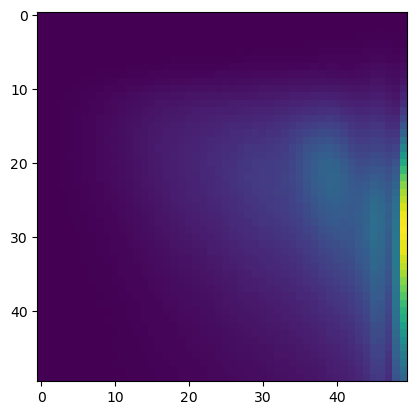

In [82]:
d, _,_ = np.histogram2d(np.array(Tr_n['logE_nu']), np.array(n_val), 50)
#d, _,_ = np.histogram2d([1]*50 + [10]*50,[1]*100, 100)
plt.imshow(d)

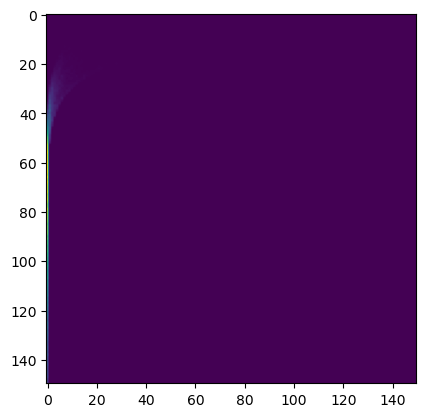

In [100]:
d, _,_ = np.histogram2d(np.array(Tr_n['logE_nu'])[:100000], atm_n[:100000], 150)
#d, _,_ = np.histogram2d([1]*50 + [10]*50,[1]*100, 100)
plt.imshow(d)

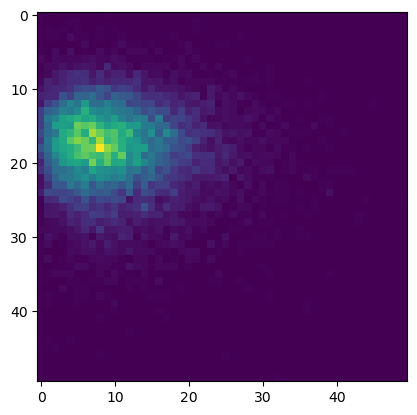

In [81]:
d, _,_ = np.histogram2d(np.array(Tr_m['logE_mu']), np.array(m_val), 50)
#d, _,_ = np.histogram2d([1]*50 + [10]*50,[1]*100, 100)
plt.imshow(d)

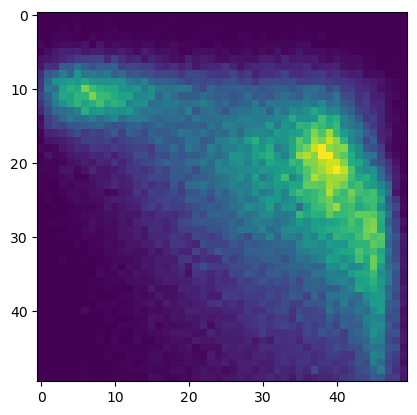

In [75]:
Tr = np.concatenate((np.array(Tr_n['logE_nu'])[:100000], np.array(Tr_m['logE_mu'])))
vall = np.concatenate((np.array(n_val)[:100000], np.array(m_val)))
d, _,_ = np.histogram2d(Tr, vall, 50)
plt.imshow(d)

In [109]:
# Test MVAs
factory.TestAllMethods()

# Evaluate MVAs
factory.EvaluateAllMethods()    

# Save the output.
outfile.Close()

<HEADER> Factory                  : Test all methods
<HEADER> Factory                  : Test method: BDT for Classification performance
                         : 
<HEADER> BDT                      : [dataset] : Evaluation of BDT on testing sample (2080 events)
                         : Elapsed time for evaluation of 2080 events: 0.0369 sec       
<HEADER> Factory                  : Evaluate all methods
<HEADER> Factory                  : Evaluate classifier: BDT
                         : 
<HEADER> BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
<WARNING> <WARNING>                : Variable "f14" has zero, negative, or NaN RMS^2: 0 ==> set to zero. Please check the variable content
<WARNING> <WARNING>                : Variable "f14" has zero, negative, or NaN RMS^2: 0 ==> set to zero. Please check the variable content
<WARNING> <WARNING>                : Variable "f14" has zero, negative, or NaN

0%, time left: unknown
6%, time left: 0 sec
12%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
31%, time left: 0 sec
37%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
56%, time left: 0 sec
62%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
81%, time left: 0 sec
87%, time left: 0 sec
94%, time left: 0 sec


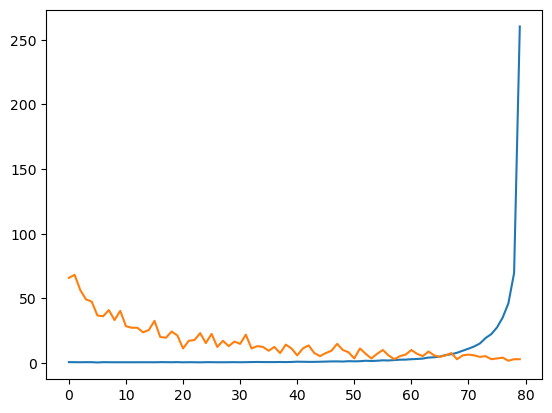

In [26]:
plt.plot(n1_ad[20:])
plt.plot(n3_ad  [20:])

In [36]:
print([(sum(n2_ad[10*i:])/sum(n2_ad), sum(n2_r[10*i:])/sum(n2_r) ) for i in range(10)])
[(sum(n3_ad[:10*i])/sum(n3_ad), sum(n3_r[:10*i])/sum(n3_r) ) for i in range(10)]

[(1.0, 1.0), (0.9690518055109009, 0.9974341602585768), (0.9420587517711184, 0.9818455144154611), (0.9188196392003246, 0.9435605987526344), (0.8958567102516006, 0.8827921767789206), (0.8731002415386361, 0.8035625107280632), (0.8474461144465366, 0.7045054489174172), (0.8163244562411226, 0.5790528322597507), (0.7701993083975548, 0.4099614462114614), (0.6723763651588669, 0.24075021410214942)]


[(0.0, 0.0),
 (0.7071960297766723, 0.17610776320453753),
 (0.8465792272243877, 0.5133640552995395),
 (0.9032967032967032, 0.7795817086139671),
 (0.9332151719248496, 0.9093938319744777),
 (0.9531371853952503, 0.9638426090038998),
 (0.9685218007798657, 0.988231123714995),
 (0.9797943991492384, 0.9964551577454808),
 (0.9873803615739104, 0.9988656504785541),
 (0.9951081176887631, 0.9995746189294578)]

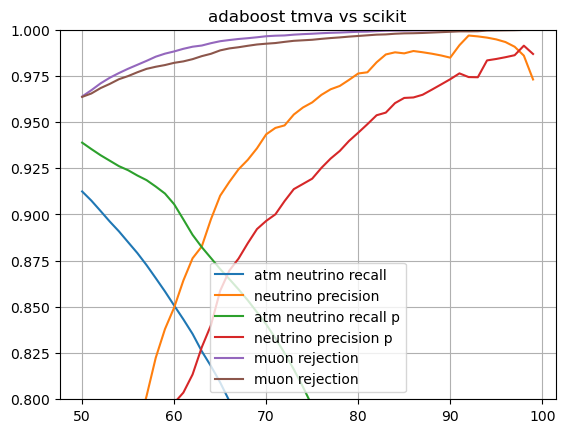

In [119]:
cut = [i for i in range(50, 100)]
atm = [sum(n1_r[c:])/( sum(n1_r)) for c in cut]
cosm = [sum(n2_r[c:])/( sum(n2_r))for c in cut]
truep = [sum(n1_r[c:] + n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
rejm = [1 - sum(n3_r[c:])/ sum(n3_r) for c in cut]
truepc = [sum(n2_r[c:])/ sum(n1_r[c:] + n2_r[c:] + n3_r[c:]) for c in cut]
cut = [i for i in range(50, 100)]
atm1 = [sum(n1_ad[c:])/( sum(n1_ad)) for c in cut]
cosm1 = [sum(n2_ad[c:])/( sum(n2_ad))for c in cut]
truep1 = [sum(n1_ad[c:] + n2_ad[c:])/ sum(n1_ad[c:] + n2_ad[c:] + n3_ad[c:]) for c in cut]
rejm1 = [1 - sum(n3_ad[c:])/ sum(n3_ad) for c in cut]
plt.plot(cut, atm, label='atm neutrino recall')
#plt.plot(cut, cosm,  label='cosm neutrino recall')
plt.plot(cut, truep, label='neutrino precision')
plt.plot(cut, atm1, label='atm neutrino recall p')
#plt.plot(cut, cosm1,  label='cosm neutrino recall p')
plt.plot(cut, truep1, label='neutrino precision p')
#plt.plot(cut, truepc, label='cosm neutrino precision')
plt.plot(cut, rejm, label='muon rejection')
plt.plot(cut, rejm1, label='muon rejection')
plt.legend(loc='lower center')
plt.title('adaboost tmva vs scikit')
plt.grid()
plt.ylim(0.8,1)
#plt.yscale('log')
plt.show()

# Finally finding model with similar results as TMVA
Although the histograms do not seem good, with a high enough cutwe can get good results \
Optimization is done by hand, techiniques as grid search can be used for better results

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric='map',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)


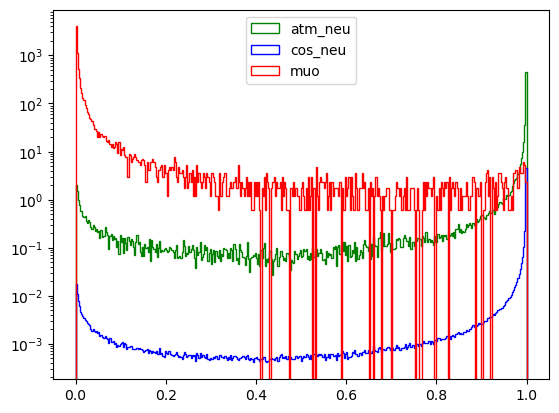

In [196]:
### xgb model
model_xgb = XGBClassifier(max_depth = 4, n_estimators=60,  eta=0.2,
    eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5)  
print(model_xgb.fit(X_train_, y_train_))
#xgboost 1-1 analogy
prob_eval_n = model_xgb.predict_proba(df_n_eval)
prob_eval_m = model_xgb.predict_proba(df_m_eval)
n1, x1, _ = plt.hist(prob_eval_n[:,1], 400,range=(0,1), log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2, x2, _ =plt.hist(prob_eval_n[:,1], 400, range=(0,1), log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3, x3, _ =plt.hist(prob_eval_m[:,1], 400, range=(0,1), log=True, weights=[muons_scale]*prob_eval_m[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.show()

Direct comparison of the models

In [197]:
from tabulate import tabulate
#ccc = 2* np.array([80, 77, 74, 68, 65, 83, 86, 89, 92, 95, 97, 99])
ccc = [390, 391, 392, 393, 394, 395,396, 397, 398, 399]
col_names = ['cut', 'muons remain', 'muons rejected', 'muons rej per', 'neutrinos rem', 'neutr rej', 'efficiency', 'purity']

data = [('70 TMVA', sum(n3_r[70:]), sum(n3_r[:70]), sum(n3_r[:70])/sum(n3_r) , sum(n2_r[70:]), sum(n2_r[:70]), sum( n2_r[70:])/sum( n2_r),
        sum(n2_r[70:] + n1_r[70:])/sum(n1_r[70:] + n2_r[70:] + n3_r[70:]))]
data.append(('80 TMVA', sum(n3_r[80:]), sum(n3_r[:80]), sum(n3_r[:80])/sum(n3_r) , sum(n2_r[80:]), sum(n2_r[:80]), sum( n2_r[80:])/sum( n2_r),
        sum(n2_r[80:] + n1_r[80:])/sum(n1_r[80:] + n2_r[80:] + n3_r[80:])))
for cc in ccc:
        data.append((str(cc) + ' sc', sum(n3[cc:]), sum(n3[:cc]), sum(n3[:cc])/sum(n3) , sum(n2[cc:]), sum(n2[:cc]), sum(n2[cc:])/sum( n2),
                sum(n2[cc:] + n1[cc:])/sum(n1[cc:] + n2[cc:] + n3[cc:])))

print(tabulate(data, headers=col_names, tablefmt="grid", showindex="always"))

+----+---------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|    | cut     |   muons remain |   muons rejected |   muons rej per |   neutrinos rem |   neutr rej |   efficiency |   purity |
+====+=========+================+==================+=================+=================+=============+==============+==========+
|  0 | 70 TMVA |        7.71459 |          8362.61 |        0.999078 |         4.75645 |    0.947514 |     0.833885 | 0.98395  |
+----+---------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  1 | 80 TMVA |        1.18686 |          8369.14 |        0.999858 |         4.08577 |    1.61819  |     0.716305 | 0.996809 |
+----+---------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  2 | 390 sc  |       39.1664  |          8331.16 |        0.995321 |         5.1631  |    0.540

10 - 1
max_depth = 4, n_estimators=30,  eta=0.2,
    eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5 -> 791 reproduce

(max_depth = 4, n_estimators=50,  eta=0.2,
    eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5) -> 398 7.12 muons, 476.7 neutr +++
(max_depth = 4, n_estimators=60,  eta=0.2,
    eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5) -> 398 7.7 mu, 484.6 neutr +++++
(max_depth = 4, n_estimators=40,  eta=0.2,
    eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5)  -> 397 7.7 mu, 481.6 neutr

(max_depth = 4, n_estimators=60,  eta=0.2,
     objective = 'binary:logistic', reg_lambda=5) ->398 7.7 mu 4.82 neu 
    
(kai xwris reg paromoia apotelemsata)

1-1
(max_depth = 4, n_estimators=60,  eta=0.2,
    eval_metric = 'map', objective = 'binary:logistic', reg_lambda=5) -> 391 reproduce


----- primary importance --- eta = 0.2

### Similar results accomplishe with CatBoost

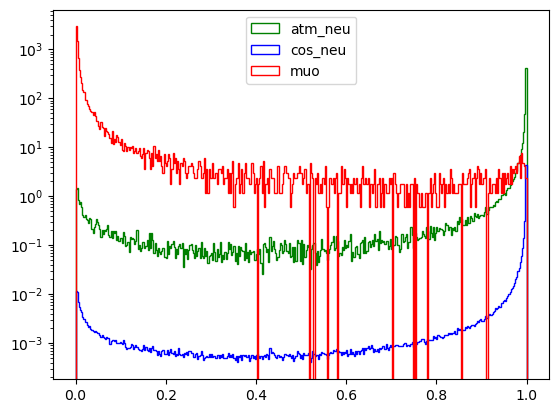

In [240]:
from catboost import CatBoostClassifier
model_ctb = CatBoostClassifier(
    iterations=11, 
    learning_rate=0.8, 
    loss_function='CrossEntropy'
)

model_ctb.fit(X_train_, y_train_, 
        verbose=False
)

prob_eval_n_c = model_ctb.predict_proba(df_n_eval)
prob_eval_m_c = model_ctb.predict_proba(df_m_eval)
n1c, x1c, _ = plt.hist(prob_eval_n_c[:,1], 400,range=(0,1), log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2c, x2c, _ =plt.hist(prob_eval_n_c[:,1], 400, range=(0,1), log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')
n3c, x3c, _ =plt.hist(prob_eval_m_c[:,1], 400, range=(0,1), log=True, weights=[muons_scale]*prob_eval_m_c[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
plt.show()

In [241]:
from tabulate import tabulate
#ccc = 2* np.array([88, 90,91, 92, 93,94,95, 96, 97, 98, 99])
ccc = [390, 391, 392, 393, 394, 395,396, 397, 398, 399]
col_names = ['cut', 'muons remain', 'muons rejected', 'muons rej per', 'neutrinos rem', 'neutr rej', 'efficiency', 'purity']

data = [('70 TMVA', sum(n3_r[70:]), sum(n3_r[:70]), sum(n3_r[:70])/sum(n3_r) , sum(n2_r[70:]), sum(n2_r[:70]), sum( n2_r[70:])/sum( n2_r),
        sum(n2_r[70:] + n1_r[70:])/sum(n1_r[70:] + n2_r[70:] + n3_r[70:]))]
data.append(('80 TMVA', sum(n3_r[80:]), sum(n3_r[:80]), sum(n3_r[:80])/sum(n3_r) , sum(n2_r[80:]), sum(n2_r[:80]), sum( n2_r[80:])/sum( n2_r),
        sum(n2_r[80:] + n1_r[80:])/sum(n1_r[80:] + n2_r[80:] + n3_r[80:])))
for cc in ccc:
        data.append((str(cc) + ' sc', sum(n3c[cc:]), sum(n3c[:cc]), sum(n3c[:cc])/sum(n3c) , sum(n2c[cc:]), sum(n2c[:cc]), sum(n2c[cc:])/sum( n2c),
                sum(n2c[cc:] + n1c[cc:])/sum(n1c[cc:] + n2c[cc:] + n3c[cc:])))

print(tabulate(data, headers=col_names, tablefmt="grid", showindex="always"))

+----+---------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|    | cut     |   muons remain |   muons rejected |   muons rej per |   neutrinos rem |   neutr rej |   efficiency |   purity |
+====+=========+================+==================+=================+=================+=============+==============+==========+
|  0 | 70 TMVA |        7.71459 |          8362.61 |        0.999078 |         4.75645 |    0.947514 |     0.833885 | 0.98395  |
+----+---------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  1 | 80 TMVA |        1.18686 |          8369.14 |        0.999858 |         4.08577 |    1.61819  |     0.716305 | 0.996809 |
+----+---------+----------------+------------------+-----------------+-----------------+-------------+--------------+----------+
|  2 | 390 sc  |       44.5072  |          8325.82 |        0.994683 |         5.13252 |    0.571

(
    iterations=9, 
    learning_rate=0.8, 
    loss_function='CrossEntropy'
) -> 190 7.7 0.984

### An attempt to approximate TMVA results stacking a polynomial regressor on top of sklearn model

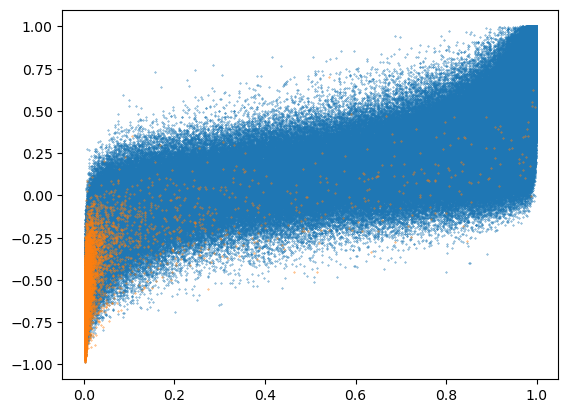

In [113]:
plt.scatter(prob_eval_n[:,1], n_val, s=0.1)
plt.scatter(prob_eval_m[:,1], m_val, s=0.1)

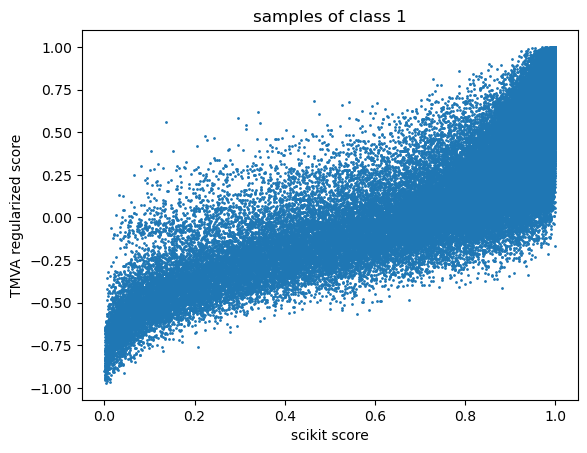

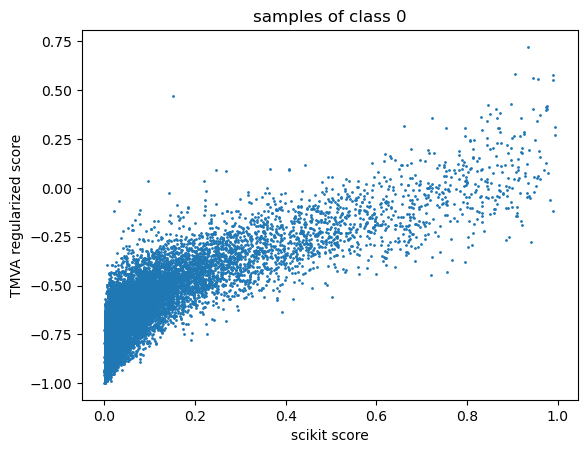

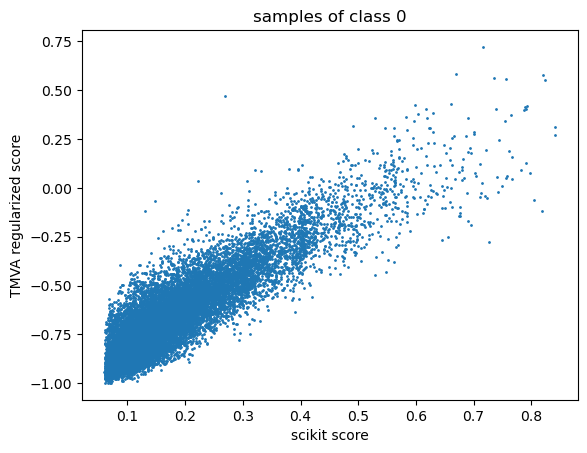

In [103]:
plt.scatter( prob_eval_n_ad[:100000,1],n_val[:100000], s=1)
plt.xlabel('scikit score')
plt.ylabel('TMVA regularized score')
plt.title('samples of class 1')
plt.show()
plt.scatter( prob_eval_m_ad[:14000,1], m_val[:14000], s=1)
plt.xlabel('scikit score')
plt.ylabel('TMVA regularized score')
plt.title('samples of class 0')
plt.show()
plt.scatter( poly_pred[:14000], m_val[:14000], s=1)
plt.xlabel('scikit score')
plt.ylabel('TMVA regularized score')
plt.title('samples of class 0')
plt.show()

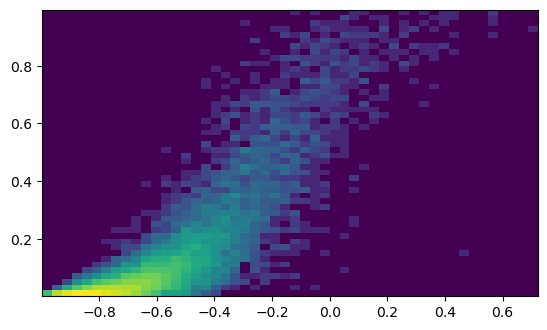

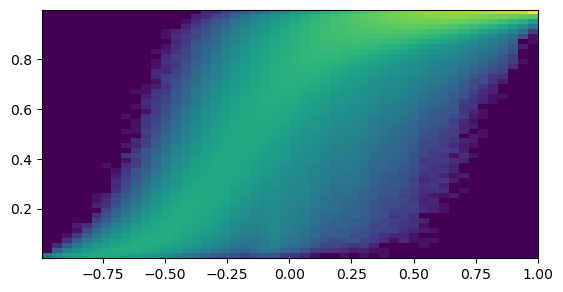

In [102]:
from matplotlib.colors import LogNorm
#d, _,_ = np.histogram2d(m_val, prob_eval_m_ad[:,1], 20, norm=LogNorm())
#d, _,_ = np.histogram2d([1]*50 + [10]*50,[1]*100, 100)
#plt.imshow(d)
H, xedges, yedges = np.histogram2d(m_val, prob_eval_m_ad[:,1], bins=(50, 50))
H = np.log(H + 1)
plt.imshow(H.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],  origin='lower')
plt.show()
H, xedges, yedges = np.histogram2d(n_val, prob_eval_n_ad[:,1], bins=(50, 50))
H = np.log(H + 1)
plt.imshow(H.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],  origin='lower')
plt.show()

In [24]:
prob_eval_m_ad[:,1].shape, m_val.shape

((14105,), (14105,))

In [6]:
n_val_ = (n_val + 1)/2
m_val_ = (m_val + 1)/2

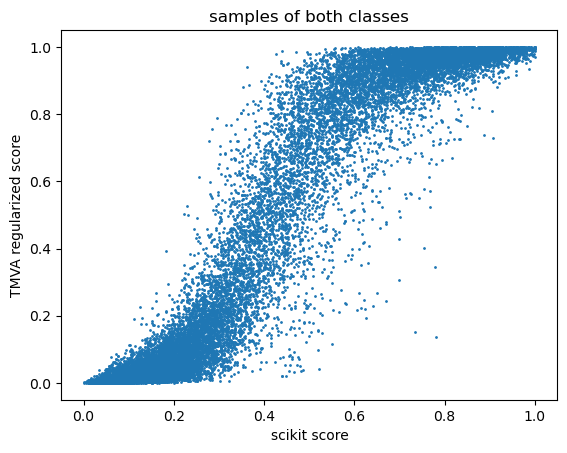

In [50]:
a = np.concatenate((prob_eval_m_ad[:10000,1], prob_eval_n_ad[:10000,1] ))
b = np.concatenate((m_val_[:10000], n_val_[:10000]))
plt.xlabel('scikit score')
plt.ylabel('TMVA regularized score')
plt.title('samples of both classes')
plt.scatter( b, a,  s=1)
plt.show()

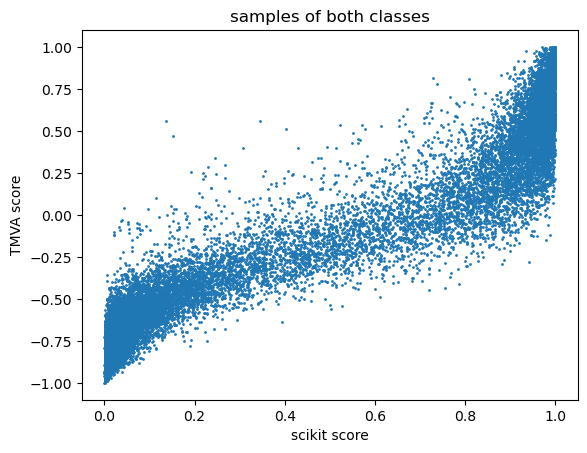

In [82]:
a = np.concatenate((prob_eval_m_ad[:10000,1], prob_eval_n_ad[:10000,1] ))
b = np.concatenate((m_val[:10000], n_val[:10000]))
plt.xlabel('scikit score')
plt.ylabel('TMVA score')
plt.title('samples of both classes')
plt.scatter( a, b,  s=1)
plt.show()

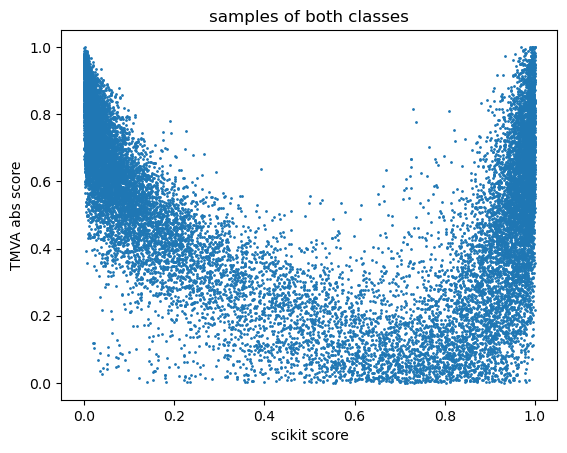

In [83]:
a = np.concatenate((prob_eval_m_ad[:10000,1], prob_eval_n_ad[:10000,1] ))
b = np.abs(np.concatenate((m_val[:10000], n_val[:10000])))
plt.xlabel('scikit score')
plt.ylabel('TMVA abs score')
plt.title('samples of both classes')
plt.scatter( a, b,  s=1)
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
 
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(a)
 
poly.fit(X_poly, b)

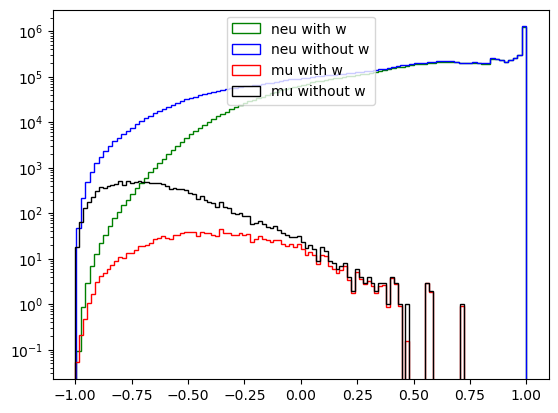

In [90]:
plt.hist(n_val, 100, log=True, weights= prob_eval_n_ad[:,1],  histtype=u'step', label='neu with w', color='g' )
plt.hist(n_val, 100, log=True,   histtype=u'step', label='neu without w', color='b' )
plt.hist(m_val, 100, log=True, weights= prob_eval_m_ad[:,1],  histtype=u'step', label='mu with w', color='r' )
plt.hist(m_val, 100, log=True,   histtype=u'step', label='mu without w', color='k' )
#plt.hist(m_val, 100, log=True, weights= prob_eval_m_ad[:,1],  histtype=u'step', label='atm_neu', color='r' )
plt.legend(loc='upper center')
plt.show()

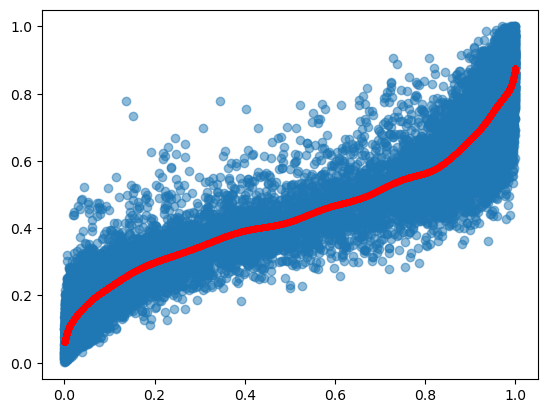

In [78]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
#x = [1,2,3,4,5,6,7,8]
#y = [i**2 for i in x]
poly = PolynomialFeatures(degree=20)
X_poly = poly.fit_transform(np.reshape(a, (-1,1)))

poly_model = LinearRegression().fit(X_poly,b)
poly_pred = poly_model.predict(X_poly)

plt.scatter(a,b, alpha=0.5)
plt.plot(a, poly_pred, color='red', linestyle='', marker='.', lw=0.1)


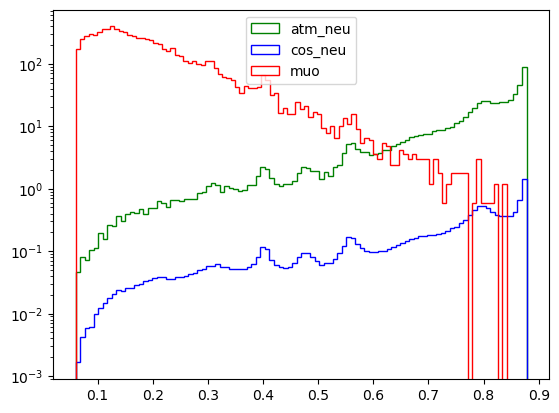

In [79]:
### ada boost
X_poly = poly.fit_transform(np.reshape(prob_eval_n_ad[:,1], (-1,1)))
poly_pred = poly_model.predict(X_poly)
n1_ad, x1_ad, _ = plt.hist(poly_pred, 100, log=True, weights= atm_nu_scale * atm_n,  histtype=u'step', label='atm_neu', color='g' )
n2_ad, x2_ad, _ =plt.hist(poly_pred, 100, log=True, weights= cosmic_nu_scale * ice_n, histtype=u'step', label='cos_neu', color='b')

X_poly = poly.fit_transform(np.reshape(prob_eval_m_ad[:,1], (-1,1)))
poly_pred = poly_model.predict(X_poly)

n3_ad, x3_ad, _ =plt.hist(poly_pred, 100, log=True, weights=[muons_scale]*prob_eval_m_ad[:,1].shape[0], histtype=u'step', label='muo', color='r')
#n4, x4, _ = plt.hist(prob_data[i][:,1], 200, log=True, weights=[data_scale]*prob_data[i][:,1].shape[0], histtype=u'step', label='data', color='k')
#plt.plot(x1[:200], n1+n2+n3, label='MC sum', color='m')
plt.legend(loc='upper center')
#plt.savefig('ada_boost.png')
plt.show()

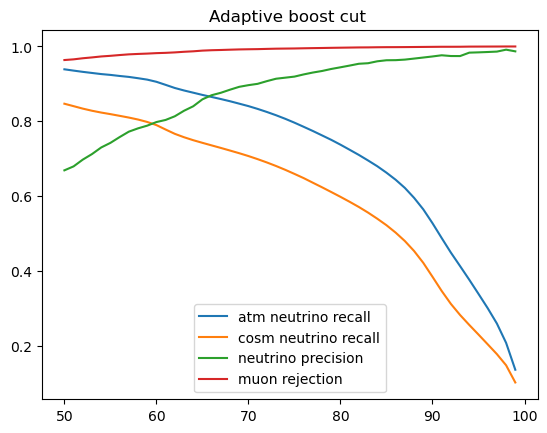

In [80]:
cut = [i for i in range(50, 100)]

atm_ada = [sum(n1_ad[c:])/( sum(n1_ad)) for c in cut]
cosm_ada = [sum(n2_ad[c:])/( sum(n2_ad))for c in cut]
truep_ada = [sum(n1_ad[c:] + n2_ad[c:])/ sum(n1_ad[c:] + n2_ad[c:] + n3_ad[c:]) for c in cut]
truepc_ada = [sum(n2_ad[c:])/ sum(n1_ad[c:] + n2_ad[c:] + n3_ad[c:]) for c in cut]
rejm_ada= [1 - sum(n3_ad[c:])/ sum(n3_ad) for c in cut]
plt.plot(cut, atm_ada, label='atm neutrino recall')
plt.plot(cut, cosm_ada,  label='cosm neutrino recall')
plt.plot(cut, truep_ada, label='neutrino precision')
plt.plot(cut, rejm_ada, label='muon rejection')
#plt.plot(cut, truepc_ada, label='cosm neutrino precision')
plt.legend(loc='lower center')
plt.title('Adaptive boost cut ')
plt.show()

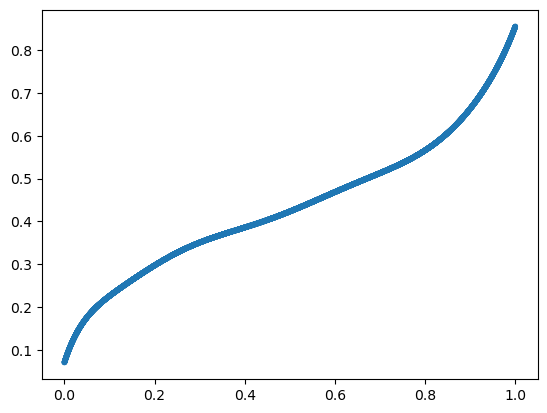

In [77]:
zz = np.arange(0, 1, 0.0001).reshape(-1,1)
xx = poly.fit_transform(zz)
plt.scatter(zz, poly_model.predict(xx), linestyle='', marker='.', lw=0.05 )

In [ ]:
poly.fit_transform()